In [1]:
#%%
# Python code to analyse forecast output and produce Fisher Matrices
# -*- coding: utf-8 -*-

import numpy as np
import math
import copy
import sympy
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import matplotlib.animation as animation
import matplotlib as mpl
import camb
import scipy.interpolate as scipy
import scipy.stats as stats
import scipy.cluster as cluster
from camb import model, initialpower, symbolic
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import time

# Code to plot transfer functions from camb

global FILEPATH
#FILEPATH = "/Users/cb607/Documents/Power_Spectrum_Calc"
FILEPATH = "/cosma8/data/dp203/dc-brow6"
# Colourblind friendly colour cycle - Bang Wong, Points of view: Colour Blindness, Nature 8, 441 (2011)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['xkcd:orange','xkcd:sky blue','xkcd:bluish green','xkcd:reddish purple','xkcd:blue','xkcd:vermillion','xkcd:yellow','xkcd:black'])

# conNumLim = 10000, rcond = condNumMultiplier/conNumLim
condNumMultiplier = 10.**(-8)


#############
# FUNCTIONS #
#############


#########################################
# CORRELATION MATRIX PLOTTING FUNCTIONS #
#########################################

# Used in class Fisher Matrix
def correlationPlotter(corr, labelLimits, labelNames, colors, title="", cmap="Blues"):
    labels = labelLimits
    fig, ax = plt.subplots()
    im = ax.imshow(corr, cmap=cmap, vmin=-1, vmax=1)

    # create axes next to plot
    divider = make_axes_locatable(ax)
    axcb = divider.append_axes("right", size="5%", pad=0.05)
    axb = divider.append_axes("bottom", "10%", pad=0.06, sharex=ax)
    axl = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
    axb.invert_yaxis()
    axl.invert_xaxis()
    axb.axis("off")
    axl.axis("off")

    fig.colorbar(im, ticks=[-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0], cax=axcb)

    # plot colored bar plots to the axes
    barkw = dict( color=colors, linewidth=0.72, ec="k", clip_on=False, align='edge',)
    axb.bar(labels[:,0]-0.5,np.ones(len(labels)), width=np.diff(labels, axis=1).flatten(), **barkw)
    axl.barh(labels[:,0]-0.5,np.ones(len(labels)), height=np.diff(labels, axis=1).flatten(), **barkw)

    # set margins to zero again
    ax.margins(0)
    ax.tick_params(axis="both", bottom=0, left=0, labelbottom=0,labelleft=0)
    # Label the boxes
    textkw = dict(ha="center", va="center", fontsize="small")
    for i in range(len(labelNames)):
        k = labels[i][0]
        l = labels[i][1]
        axb.text(((k+l)/2.)-0.5,0.5, labelNames[i], **textkw)
        axl.text(0.5,((k+l)/2.)-0.5, labelNames[i], rotation=-90,**textkw)
    plt.show()

def collectionCorrelationPlotter(corrs, labelLimits, labelNames, colors, title="", cmap="Blues"):
    fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace':0, 'wspace':0})
    im = subCorrelationPlotter(ax=axs[0,0], corr=corrs[0], labelLimits=labelLimits, colors=colors, cmap=cmap, labelLeft=True)
    im = subCorrelationPlotter(ax=axs[0,1], corr=corrs[1], labelLimits=labelLimits, colors=colors, cmap=cmap)
    im = subCorrelationPlotter(ax=axs[1,0], corr=corrs[2], labelLimits=labelLimits, colors=colors, cmap=cmap, labelLeft=True, labelBottom=True)
    im = subCorrelationPlotter(ax=axs[1,1], corr=corrs[3], labelLimits=labelLimits, colors=colors, cmap=cmap, labelBottom=True)
    patchList = []
    for i in range(len(labelNames)):
        patchList.append(mpatches.Patch(color=colors[i], label=labelNames[i]))
    axs[0,2].legend(handles=patchList, loc='upper left')
    axs[0,2].axis('off')
    divider = make_axes_locatable(axs[1,2])
    axcb = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ticks=[-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0], cax=axcb)
    plt.show()

def subCorrelationPlotter(ax, corr, labelLimits, colors, cmap="Blues", labelLeft=False, labelBottom=False):
    labels = labelLimits
    im = ax.imshow(corr, cmap=cmap, vmin=-1, vmax=1)

    # create axes next to plot
    divider = make_axes_locatable(ax)
    # plot colored bar plots to the axes
    barkw = dict( color=colors, linewidth=0.72, ec="k", clip_on=False, align='edge',)
    if(labelBottom):
        axb = divider.append_axes("bottom", "10%", pad=0.06, sharex=ax)
        axb.invert_yaxis()
        axb.axis("off")
        axb.bar(labels[:,0]-0.5,np.ones(len(labels)), width=np.diff(labels, axis=1).flatten(), **barkw)
    if(labelLeft):
        axl = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
        axl.invert_xaxis()
        axl.axis("off")
        axl.barh(labels[:,0]-0.5,np.ones(len(labels)), height=np.diff(labels, axis=1).flatten(), **barkw)

    # set margins to zero again
    ax.margins(0)
    ax.tick_params(axis="both", bottom=0, left=0, labelbottom=0,labelleft=0)
    return im



class Instrument:
    """
    ######################################################################
    Instrument base class
    Base class for derived instrument classes to be used in model classes.
    ######################################################################

    fSky(float)
        Float number.
        Fraction of sky covered by survey.

    name(float)
        string name.
        Name of instrument in output files.
    """

    def __init__(self, fSky, name):
        self.fSky=fSky
        self.name=name


class GalaxyInstrument(Instrument):
    """
    ####################################################
    Galaxy Instrument class
    To be used in Model classes for computing variances.
    Specific to a galaxy type being measured.
    ####################################################

    fSky(float)
        Float number.
        Fraction of sky covered by survey.

    galNumber(float)
        Float number.
        Number density of galaxies in gal/deg^2.

    galName(string)
        String suffix used in files.
        Files can use a final suffix to distinguish between different galaxy types, which is noted here.
    """

    def __init__(self, fSky, galNumber, galName):
        super().__init__(fSky, galName)
        self.galNumber=galNumber
        self.galName=galName

    def galError(self):
        N = 1/(self.galNumber*((180/np.pi)**2.))
        return N

    def shotNoise(self, ell):
        return self.galError()


class LensingInstrument(Instrument):
    """
    ####################################################
    Lensing Instrument class
    To be used in Model classes for computing variances.
    Specific to a source galaxy type being measured.
    ####################################################

    fSky(float)
        Float number.
        Fraction of sky covered by survey.

    galNumber(float)
        Float number.
        Number of density of galaxies in gal/arcmin^2.

    galName(string)
        String suffix used in files.
        Files can use a final suffix to distinguish between different galaxy types, which is noted here.

    sigmae(float)
        Float number.
        Ellipticity dispersion, sigma_epsilon.
    """

    def __init__(self, fSky, galNumber, galName, sigmae):
        super().__init__(fSky, galName)
        self.galNumber=galNumber
        self.galName=galName
        self.sigmae=sigmae

    def galError(self):
        N = self.sigmae*self.sigmae/((self.galNumber*60*60)*((180/np.pi)**2.))
        return N

    def shotNoise(self, ell):
        return self.galError()


class CMBInstrument(Instrument):
    """
    ###########################################################
    CMB Instrument class
    To be used in Model classes for computing cosmic variances.
    ###########################################################

    fSky(float)
        Float number.
        Fraction of sky covered by survey.

    thetaBeam(float)
        Float number.
        Beam width in arc minutes.

    sigmaT(float)
        Float number.
        Temperature variance in K.

    sigmaP(float)
        Float number.
        Polarisation variance in K.
    """

    def __init__(self, fSky, thetaBeam, sigmaT, sigmaP):
        super().__init__(fSky, "")
        self.thetaBeam=thetaBeam
        self.sigmaT=sigmaT
        self.sigmaP=sigmaP
        self.frequencies = len(thetaBeam)

    def beamError(self, ell, temp=True):
        Noise = 0
        for i in range(self.frequencies):
            tBeam=self.thetaBeam[i]*2*np.pi/(60*360)
            sT = self.sigmaT[i]/2.7255
            sP = self.sigmaP[i]/2.7255
            B = np.exp(-(ell*(ell+1)*tBeam*tBeam)/(8.*np.log(2)))
            if(temp):
                Noise = Noise + 1/(tBeam*tBeam*sT*sT/B)
            else:
                Noise = Noise + 1/(tBeam*tBeam*sP*sP/B)
        return 1/Noise

    def shotNoise(self, ell):
        return self.beamError(ell=ell)


class CMBInstrumentEMode(Instrument):
    """
    ###########################################################
    CMB Instrument class
    To be used in Model classes for computing cosmic variances.
    ###########################################################

    fSky(float)
        Float number.
        Fraction of sky covered by survey.

    thetaBeam(float)
        Float number.
        Beam width in arc minutes.

    sigmaT(float)
        Float number.
        Temperature variance in K.

    sigmaP(float)
        Float number.
        Polarisation variance in K.
    """

    def __init__(self, fSky, thetaBeam, sigmaT, sigmaP):
        super().__init__(fSky, "")
        self.thetaBeam=thetaBeam
        self.sigmaT=sigmaT
        self.sigmaP=sigmaP
        self.frequencies = len(thetaBeam)

    def beamError(self, ell):
        Noise = 0
        for i in range(self.frequencies):
            tBeam=self.thetaBeam[i]*2*np.pi/(60*360)
            sP = self.sigmaP[i]/2.7255
            B = np.exp(-(ell*(ell+1)*tBeam*tBeam)/(8.*np.log(2)))
            Noise = Noise + 1/(tBeam*tBeam*sP*sP/B)
        return 1/Noise

    def shotNoise(self, ell):
        return self.beamError(ell=ell)



class Model:
    """
    #########################################################################
    Model base class
    Base class for derived model classes to be used in Fisher Matrix classes.
    #########################################################################

    paramNames(array-like(string))
        String array of parameter names in your preferred order

    paramNumber(int)
        Int of number of parameters.

    paramValues(array-like(float))
        Float array of parameter values following the order of paramNames

    paramDevs(array-like(float))
        Float array of parameter deviations following the order of paramNames.
        The deviations can be at any scale you wish, allowing for parameter rescaling, e.g. A_s/A_s,fid.

    ellArray(array-like(int))
        Int array of spherical harmonic ell values to be used in computation.
    """

    def __init__(self, paramNames, paramValues, paramDevs, ellArray):
        self.paramNames=paramNames
        self.paramNumber=len(paramNames)
        self.paramValues=paramValues
        self.paramDevs=paramDevs
        self.ellArray=ellArray



class FullForecast(Model):
    """
    #########################################
    Full Forecast model class
    To be used in a Fisher Matrix class
    Contains all observables for the forecast
    #########################################

    observables(dictionary-like(string:bool))
        Bool array of T/F whether to calculate specific observables:
        CMB, CMBLens, ISW, Gal-Gal, Lens-Lens, Gal-Gal Lens, CMBLens-Lens

    paramNames(array-like(string))
        String array of parameter names in your preferred order

    paramValues(array-like(float))
        Float array of parameter values following the order of paramNames

    paramDevs(array-like(float))
        Float array of parameter deviations following the order of paramNames.
        The deviations can be at any scale you wish, allowing for parameter rescaling, e.g. A_s/A_s,fid.

    ellArray(array-like(int))
        Int array of spherical harmonic ell values to be used in computation.

    lenseInstruments(array-like(Instrument))
        LensingInstrument instance specific to lense type being measured.

    galInstruments(array-like(Instrument))
        GalaxyInstrument instance specific to galaxy type being measured.

    CMBInstrument(CMBInstrument)
        CMBInstrument instance.

    CMBellArray(array-like(int))
        Int array of ell values specific to the CMB measurements.

    CMBParamNames(array-like(string))
        String array of parameter names specific to the CMB.

    CMBParamValues(array-like(float))
        Float array of parameter values to be used in camb.

    translationToCAMBParams(array-like(int))
        Int array of indices that convert from your parameter list to the CAMB parameter list, ordered as:
        h, As, ns, omegaM, omegaB, fnu, Neff, tau, w0, wa.

    cambParamDevs(array-like(float))
        Array of deviations of your parameter list in the same units as your parameters.

    hierarchy(string)
        Neutrino mass hierarchy, following either:
        degenerate
        normal
        inverted

    suffix(string)
        String suffix used at end of file (not including galType index).
    """

    def __init__(self, observables, paramNames, paramValues, paramDevs, ellArray, lenseInstruments, galInstruments, CMBInstruments, CMBellArray, CMBParamNames, CMBParamValues, translationToCAMBParams, cambParamDevs, hierarchy="degenerate", suffix=""):
        super().__init__(paramNames, paramValues, paramDevs, ellArray)
        self.observables=observables
        self.lenseInstruments=lenseInstruments
        self.numLense = len(lenseInstruments)
        self.galInstruments=galInstruments
        self.numGal = len(galInstruments)
        self.CMBInstruments=CMBInstruments
        self.CMBellArray=CMBellArray
        self.CMBParamNames=CMBParamNames
        self.CMBParamValues=CMBParamValues
        self.cambParams=translationToCAMBParams
        self.cambParamDevs=cambParamDevs
        self.hierarchy=hierarchy
        self.suffix=suffix

    def dataFileReader(self, fileName, truncate=False):
        dataArray = []
        with open(fileName) as filestream:
            for line in filestream:
                lines = (line.rstrip("\x00"))
                lines = (lines.rstrip())
                currentLine = lines.split(",")
                dataArray.append(currentLine)
        arr = np.asarray(dataArray).astype(np.float)
        array1 = np.zeros(len(self.CMBellArray))
        array2 = np.zeros(len(self.CMBellArray))
        offset = int(round(self.CMBellArray[0]))
        for i in range(len(arr)):
            if(i>self.ellArray[0]-1 and i<self.ellArray[len(self.ellArray)-1]+1):
                array1[i-offset] = arr[i][0]
                array2[i-offset] = arr[i][1]
                if(truncate):
                    if(arr[i][1]!=0):
                        array2[i-offset] = round(arr[i][1], -int(math.floor(math.log10(abs(arr[i][1]))))+1)
                    else:
                        array2[i-offset] = arr[i][1]
        return array1, array2

    def readForecastDev(self, correlation, parameter, suffix="", truncate=False):
        C_ellpos = []
        C_ellneg = []
        correlationID = correlation[0]+correlation[1]
        corrConvertDic = {"T":["Temp",""], "k":["CMBLense",""]}
        for i in range(self.numGal):
            corrConvertDic["g"+str(i)] = ["Gal",self.galInstruments[i].galName]
        lens = False
        for i in range(self.numLense):
            if (("L"+str(i)) in correlation):
                lens = True
                galGalLense = False
                for j in range(self.numGal):
                    # Gal-Gal Lensing
                    if(("g"+str(j)) in correlation):
                        galGalLense = True
                        C_ellpos = self.generateGalGalLensSpectra(instg=self.galInstruments[j].galName, instL=self.lenseInstruments[i].galName, paramName=parameter+"+", truncate=truncate)
                        C_ellneg = self.generateGalGalLensSpectra(instg=self.galInstruments[j].galName, instL=self.lenseInstruments[i].galName, paramName=parameter+"-", truncate=truncate)
                        return C_ellpos, C_ellneg
                if(galGalLense==False):
                    lenseLense = False
                    for j in range(self.numLense):
                        if (correlationID==("L"+str(i)+"L"+str(j))):
                            lenseLense = True
                            C_ellpos = self.generateLensAutoSpectra(instL1=self.lenseInstruments[i].galName, instL2=self.lenseInstruments[j].galName, paramName=parameter+"+", truncate=truncate)
                            C_ellneg = self.generateLensAutoSpectra(instL1=self.lenseInstruments[i].galName, instL2=self.lenseInstruments[j].galName, paramName=parameter+"-", truncate=truncate)
                            return C_ellpos, C_ellneg
                    # Lens cross
                    if(lenseLense==False):
                        C_ellpos = self.generateLensCrossSpectra(instA=corrConvertDic[correlation[0]][1], instL=self.lenseInstruments[i].galName, obsName=corrConvertDic[correlation[0]][0], paramName=parameter+"+", truncate=truncate)
                        C_ellneg = self.generateLensCrossSpectra(instA=corrConvertDic[correlation[0]][1], instL=self.lenseInstruments[i].galName, obsName=corrConvertDic[correlation[0]][0], paramName=parameter+"-", truncate=truncate)
                        return C_ellpos, C_ellneg
        # No lensing (and hence no weird summed spectra)
        if(lens==False):
            name = corrConvertDic[correlation[0]][0]+corrConvertDic[correlation[1]][0]+corrConvertDic[correlation[0]][1]+corrConvertDic[correlation[1]][1]
            if (parameter=="mag" or ("shearm" in parameter)):
                C_ellpos = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+name+"Mean"+suffix+".dat", truncate=truncate)[1]
                C_ellneg = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+name+"Mean"+suffix+".dat", truncate=truncate)[1]
            else:
                C_ellpos = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+name+parameter+"+"+suffix+".dat", truncate=truncate)[1]
                C_ellneg = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+name+parameter+"-"+suffix+".dat", truncate=truncate)[1]
        return C_ellpos, C_ellneg

    def readInCMBDataParam(self, cambParamIndex):
        parameters = np.array([self.CMBParamValues, self.CMBParamValues])
        parameters[0][cambParamIndex] = parameters[0][cambParamIndex]+self.cambParamDevs[cambParamIndex]
        parameters[1][cambParamIndex] = parameters[1][cambParamIndex]-self.cambParamDevs[cambParamIndex]
        cmbMeanRateOfChange = np.zeros((len(self.CMBellArray), 4))
        CMBTTp, CMBTEp, CMBEEp, CMBLLp = self.generateCMBSpectra(parameters=parameters[0])
        CMBTTn, CMBTEn, CMBEEn, CMBLLn = self.generateCMBSpectra(parameters=parameters[1])
        for i in range(len(self.CMBellArray)):
            cmbMeanRateOfChange[i][0] = (CMBTTp[i] - CMBTTn[i])/(2*self.paramDevs[np.where(self.paramNames==self.CMBParamNames[cambParamIndex])])
            cmbMeanRateOfChange[i][1] = (CMBTEp[i] - CMBTEn[i])/(2*self.paramDevs[np.where(self.paramNames==self.CMBParamNames[cambParamIndex])])
            cmbMeanRateOfChange[i][2] = (CMBEEp[i] - CMBEEn[i])/(2*self.paramDevs[np.where(self.paramNames==self.CMBParamNames[cambParamIndex])])
            cmbMeanRateOfChange[i][3] = (CMBLLp[i] - CMBLLn[i])/(2*self.paramDevs[np.where(self.paramNames==self.CMBParamNames[cambParamIndex])])
        return cmbMeanRateOfChange

    def readInDataParam(self, paramName, paramDev, obsList, truncate=False):
        C_ell_p = []
        C_ell_n = []
        meanRateOfChange = np.zeros(len(obsList)*(len(self.CMBellArray)))
        if(len(obsList)>3): # contains enough entries to have both CMB and CMB lensing
            if(obsList[0]==["T","T"] and obsList[3]==["k","k"]):  # if observable list contains CMB and lensing measurements
                for i in range(4, len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                if(paramName in self.CMBParamNames):
                    CMBMeanRateOfChange = self.readInCMBDataParam(cambParamIndex=np.where(self.CMBParamNames==paramName))
                    for i in range(len(self.CMBellArray)):
                        for k in range(4):
                            meanRateOfChange[len(obsList)*i + k] = CMBMeanRateOfChange[i][k]
                for i in range(len(self.CMBellArray)):
                    for k in range(4, len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k-4][i] - C_ell_n[k-4][i])/(2*paramDev)
            elif(obsList[0]==["T","T"] and obsList[3]!=["k","k"]):  # if observable list contains only CMB measurements
                for i in range(3, len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                if(paramName in self.CMBParamNames):
                    CMBMeanRateOfChange = self.readInCMBDataParam(cambParamIndex=np.where(self.CMBParamNames==paramName))
                    for i in range(len(self.CMBellArray)):
                        for k in range(3):
                            meanRateOfChange[len(obsList)*i + k] = CMBMeanRateOfChange[i][k]
                for i in range(len(self.CMBellArray)):
                    for k in range(3, len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k-3][i] - C_ell_n[k-3][i])/(2*paramDev)
            elif(obsList[0]==["k","k"]):  # if observable list contains CMB Lensing only measurements
                for i in range(1, len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                if(paramName in self.CMBParamNames):
                    CMBMeanRateOfChange = self.readInCMBDataParam(cambParamIndex=np.where(self.CMBParamNames==paramName))
                    for i in range(len(self.CMBellArray)):
                        meanRateOfChange[len(obsList)*i] = CMBMeanRateOfChange[i][3]
                for i in range(len(self.CMBellArray)):
                    for k in range(1, len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k-1][i] - C_ell_n[k-1][i])/(2*paramDev)
            else:  # if observable list doesn't contain CMB measurements
                for i in range(len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                for i in range(len(self.CMBellArray)):
                    for k in range(len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k][i] - C_ell_n[k][i])/(2*paramDev)
        else: # does not contain both CMB and CMB lensing
            if(obsList[0]==["T","T"]):  # if observable list contains only CMB measurements
                for i in range(3, len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                if(paramName in self.CMBParamNames):
                    CMBMeanRateOfChange = self.readInCMBDataParam(cambParamIndex=np.where(self.CMBParamNames==paramName))
                    for i in range(len(self.CMBellArray)):
                        for k in range(3):
                            meanRateOfChange[len(obsList)*i + k] = CMBMeanRateOfChange[i][k]
                for i in range(len(self.CMBellArray)):
                    for k in range(3, len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k-3][i] - C_ell_n[k-3][i])/(2*paramDev)
            elif(obsList[0]==["k","k"]):  # if observable list contains CMB Lensing only measurements
                for i in range(1, len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                if(paramName in self.CMBParamNames):
                    CMBMeanRateOfChange = self.readInCMBDataParam(cambParamIndex=np.where(self.CMBParamNames==paramName))
                    for i in range(len(self.CMBellArray)):
                        meanRateOfChange[len(obsList)*i] = CMBMeanRateOfChange[i][3]
                for i in range(len(self.CMBellArray)):
                    for k in range(1, len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k-1][i] - C_ell_n[k-1][i])/(2*paramDev)
            else:  # if observable list doesn't contain CMB measurements
                for i in range(len(obsList)):
                    C_ell_Crossp, C_ell_Crossn = self.readForecastDev(correlation=obsList[i], parameter=paramName, suffix=self.suffix, truncate=truncate)
                    C_ell_p.append(C_ell_Crossp)
                    C_ell_n.append(C_ell_Crossn)
                for i in range(len(self.CMBellArray)):
                    for k in range(len(obsList)):
                        meanRateOfChange[len(obsList)*i+k] = (C_ell_p[k][i] - C_ell_n[k][i])/(2*paramDev)
        return meanRateOfChange

    def generateCMBSpectra(self, parameters):
        h=parameters[self.cambParams[0]]
        As=parameters[self.cambParams[1]]
        ns=parameters[self.cambParams[2]]
        omegaM=parameters[self.cambParams[3]]
        omegaB=parameters[self.cambParams[4]]
        fnu=parameters[self.cambParams[5]]
        Neff=parameters[self.cambParams[6]]
        tau=parameters[self.cambParams[7]]
        w0=parameters[self.cambParams[8]]
        wa=parameters[self.cambParams[9]]
        meffSterile=0.0
        hierarchy=self.hierarchy
        ommh2 = omegaM*h*h
        omnuh2 = fnu*ommh2
        ombh2=omegaB*h*h
        omch2=ommh2-ombh2-omnuh2
        nuMass=omnuh2*93.14
        pars = camb.CAMBparams()
        initPower = camb.InitialPowerLaw()
        initPower.set_params(As=As, ns=ns)
        pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, neutrino_hierarchy=hierarchy, 
                            num_massive_neutrinos=3, mnu=nuMass, nnu=Neff, meffsterile=meffSterile, 
                            standard_neutrino_neff=Neff, omk=0, tau=tau)
        pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
        pars.set_initial_power(initPower)
        pars.set_for_lmax(2500,lens_potential_accuracy=2)
        prs = camb.set_params(pars)
        dat = camb.get_results(prs)
        cl_camb = dat.get_lens_potential_cls(2500)
        CAMBLL = cl_camb[:,0]
        dic = dat.get_cmb_unlensed_scalar_array_dict(CMB_unit=None, raw_cl=True)
        C_ell_TT = np.zeros((len(self.CMBellArray)))
        C_ell_TE = np.zeros((len(self.CMBellArray)))
        C_ell_EE = np.zeros((len(self.CMBellArray)))
        C_ell_LL = np.zeros((len(self.CMBellArray)))
        for i in range(len(self.CMBellArray)):
            CAMBTT = dic['TxT']
            CAMBTE = dic['TxE']
            CAMBEE = dic['ExE']
            l=int(round(self.CMBellArray[i]))
            C_ell_TT[i] = CAMBTT[l]
            C_ell_TE[i] = CAMBTE[l]
            C_ell_EE[i] = CAMBEE[l]
            C_ell_LL[i] = (2*np.pi*(CAMBLL[l]))/(l*l*(l+1)*(l+1))
        return C_ell_TT, C_ell_TE, C_ell_EE, C_ell_LL

    def generateGalGalLensSpectra(self, instg, instL, paramName, truncate=False):
        C_ggL = np.zeros(len(self.CMBellArray))
        C_mG = np.zeros(len(self.CMBellArray))
        paramNameBackup = copy.deepcopy(paramName)
        if(("shearm" in paramName)):
            paramName="Mean"
        elif (paramName=="mag+"):
            paramName="Mean"
            C_mG = 0.1*self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GravGrav"+instL+instL+"Mean"+self.suffix+".dat", truncate=truncate)[1]
        elif (paramName=="mag-"):
            paramName="Mean"
            C_mG = -0.1*self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GravGrav"+instL+instL+"Mean"+self.suffix+".dat", truncate=truncate)[1]
        C_gG = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GalLenseGrav"+instg+instL+paramName+self.suffix+".dat", truncate=truncate)[1]
        C_gI = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GalLenseIntAlign"+instg+instL+paramName+self.suffix+".dat", truncate=truncate)[1]
        m = 0.001
        if(("shearm1" in paramNameBackup) and ("1" in instL)):
            if("+" in paramNameBackup):
                C_gG = (1+m)*C_gG
            else:
                C_gG = (1-m)*C_gG
        elif(("shearm2" in paramNameBackup) and ("2" in instL)):
            if("+" in paramNameBackup):
                C_gG = (1+m)*C_gG
            else:
                C_gG = (1-m)*C_gG
        elif(("shearm3" in paramNameBackup) and ("3" in instL)):
            if("+" in paramNameBackup):
                C_gG = (1+m)*C_gG
            else:
                C_gG = (1-m)*C_gG
        elif(("shearm4" in paramNameBackup) and ("4" in instL)):
            if("+" in paramNameBackup):
                C_gG = (1+m)*C_gG
            else:
                C_gG = (1-m)*C_gG
        for i in range(len(self.CMBellArray)):
            C_ggL[i] = C_gG[i]+C_gI[i]+C_mG[i]
        return C_ggL

    def generateLensAutoSpectra(self, instL1, instL2, paramName, truncate=False):
        C_LL = np.zeros(len(self.CMBellArray))
        paramNameBackup = copy.deepcopy(paramName)
        if(("shearm" in paramName)):
            paramName="Mean"
        elif (paramName=="mag+"):
            paramName="Mean"
        elif (paramName=="mag-"):
            paramName="Mean"
        C_GG = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GravGrav"+instL1+instL2+paramName+self.suffix+".dat", truncate=truncate)[1]
        C_GI = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GravIntAlign"+instL1+instL2+paramName+self.suffix+".dat", truncate=truncate)[1]
        C_IG = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GravIntAlign"+instL2+instL1+paramName+self.suffix+".dat", truncate=truncate)[1]
        C_II = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_IntAlignIntAlign"+instL1+instL2+paramName+self.suffix+".dat", truncate=truncate)[1]
        m = 0.001
        if(("shearm1" in paramNameBackup) and ("1" in instL1)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_GI = (1+m)*C_GI
            else:
                C_GG = (1-m)*C_GG
                C_GI = (1-m)*C_GI
        elif(("shearm2" in paramNameBackup) and ("2" in instL1)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_GI = (1+m)*C_GI
            else:
                C_GG = (1-m)*C_GG
                C_GI = (1-m)*C_GI
        elif(("shearm3" in paramNameBackup) and ("3" in instL1)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_GI = (1+m)*C_GI
            else:
                C_GG = (1-m)*C_GG
                C_GI = (1-m)*C_GI
        elif(("shearm4" in paramNameBackup) and ("4" in instL1)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_GI = (1+m)*C_GI
            else:
                C_GG = (1-m)*C_GG
                C_GI = (1-m)*C_GI
        m = 0.001
        if(("shearm1" in paramNameBackup) and ("1" in instL2)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_IG = (1+m)*C_IG
            else:
                C_GG = (1-m)*C_GG
                C_IG = (1-m)*C_IG
        elif(("shearm2" in paramNameBackup) and ("2" in instL2)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_IG = (1+m)*C_IG
            else:
                C_GG = (1-m)*C_GG
                C_IG = (1-m)*C_IG
        elif(("shearm3" in paramNameBackup) and ("3" in instL2)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_IG = (1+m)*C_IG
            else:
                C_GG = (1-m)*C_GG
                C_IG = (1-m)*C_IG
        elif(("shearm4" in paramNameBackup) and ("4" in instL2)):
            if("+" in paramNameBackup):
                C_GG = (1+m)*C_GG
                C_IG = (1+m)*C_IG
            else:
                C_GG = (1-m)*C_GG
                C_IG = (1-m)*C_IG
        for i in range(len(self.CMBellArray)):
            C_LL[i] = C_GG[i]+C_GI[i]+C_IG[i]+C_II[i]
        return C_LL

    def generateLensCrossSpectra(self, instA, instL, obsName, paramName, truncate=False):
        C_AL = np.zeros(len(self.CMBellArray))
        paramNameBackup = copy.deepcopy(paramName)
        if(("shearm" in paramName)):
            paramName="Mean"
        elif (paramName=="mag+"):
            paramName="Mean"
        elif (paramName=="mag-"):
            paramName="Mean"
        C_AG = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+obsName+"Grav"+instA+instL+paramName+self.suffix+".dat", truncate=truncate)[1]
        C_AI = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_"+obsName+"IntAlign"+instA+instL+paramName+self.suffix+".dat", truncate=truncate)[1]
        m = 0.001
        if(("shearm1" in paramNameBackup) and ("1" in instL)):
            if("+" in paramNameBackup):
                C_AG = (1+m)*C_AG
            else:
                C_AG = (1-m)*C_AG
        elif(("shearm2" in paramNameBackup) and ("2" in instL)):
            if("+" in paramNameBackup):
                C_AG = (1+m)*C_AG
            else:
                C_AG = (1-m)*C_AG
        elif(("shearm3" in paramNameBackup) and ("3" in instL)):
            if("+" in paramNameBackup):
                C_AG = (1+m)*C_AG
            else:
                C_AG = (1-m)*C_AG
        elif(("shearm4" in paramNameBackup) and ("4" in instL)):
            if("+" in paramNameBackup):
                C_AG = (1+m)*C_AG
            else:
                C_AG = (1-m)*C_AG
        for i in range(len(self.CMBellArray)):
            C_AL[i] = C_AG[i]+C_AI[i]
        return C_AL

    def angularSpectraCovariance(self, element, A, B, C, D, instDic, spectraDic):
        covarElement = 0
        instA = instDic[A]
        instB = instDic[B]
        instC = instDic[C]
        instD = instDic[D]
        i = element
        C_AC = spectraDic[A+C]
        ACShot = 0
        C_BD = spectraDic[B+D]
        BDShot = 0
        C_AD = spectraDic[A+D]
        ADShot = 0
        C_BC = spectraDic[B+C]
        BCShot = 0
        lensCount = (A+B+C+D).count('L')
        if(A==C):
            if(spectraDic[A+C][i]!=0):
                if(lensCount==4): # Auto-lensing shot noise. 2 components.
                    ACShot=2.*instA.shotNoise(ell=self.CMBellArray[i])
                else:
                    ACShot=instA.shotNoise(ell=self.CMBellArray[i])
        if(B==D):
            if(spectraDic[B+D][i]!=0):
                if(lensCount==4):
                    BDShot=2.*instB.shotNoise(ell=self.CMBellArray[i])
                else:
                    BDShot=instB.shotNoise(ell=self.CMBellArray[i])
        if(A==D):
            if(spectraDic[A+D][i]!=0):
                if(lensCount==4):
                    ADShot=2.*instA.shotNoise(ell=self.CMBellArray[i])
                else:
                    ADShot=instA.shotNoise(ell=self.CMBellArray[i])
        if(B==C):
            if(spectraDic[B+C][i]!=0):
                if(lensCount==4):
                    BCShot=2.*instB.shotNoise(ell=self.CMBellArray[i])
                else:
                    BCShot=instB.shotNoise(ell=self.CMBellArray[i])
        fSky=max(instA.fSky, instB.fSky, instC.fSky, instD.fSky)
        covarElement = ((((C_AC[i]+ACShot)*(C_BD[i]+BDShot))+((C_AD[i]+ADShot)*(C_BC[i]+BCShot)))/(fSky*((2*self.CMBellArray[i])+1)))
        return covarElement

    def covariance(self, spectraDic, instDic, obsList):
        covarArray = np.zeros((len(obsList)*len(self.CMBellArray), len(obsList)*len(self.CMBellArray)))
        for l in range(len(self.CMBellArray)):
            for i in range(len(obsList)):
                for j in range(len(obsList)):
                    covarArray[len(obsList)*l + i][len(obsList)*l + j] = self.angularSpectraCovariance(element=l, A=obsList[i][0], B=obsList[i][1], C=obsList[j][0], D=obsList[j][1], instDic=instDic, spectraDic=spectraDic)
        return covarArray

    def generateModel(self):
        tStart = time.time()
        covariance=None
        obsList = []
        spectraDic = {}
        if(self.observables["CMB"]):
            obsList.append(["T","T"])
            obsList.append(["T","E"])
            obsList.append(["E","E"])
        if(self.observables["CMBLens"]):
            obsList.append(["k","k"])
        if(covariance is None):
            instDic = {"T":self.CMBInstruments[0], "E":self.CMBInstruments[1], "k":self.CMBInstruments[0]}
            # Generate CMB spectra for covariance
            TT, TE, EE, LL = self.generateCMBSpectra(parameters=self.CMBParamValues)
            # add to spectra dictionary
            spectraDic["TT"] = TT
            spectraDic["TE"] = TE
            spectraDic["ET"] = spectraDic["TE"]
            spectraDic["Tk"] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_CMBLenseTempMean"+self.suffix+".dat", truncate=False)[1]
            spectraDic["kT"] = spectraDic["Tk"]
            spectraDic["EE"] = EE
            spectraDic["Ek"] = np.zeros((len(self.CMBellArray)))
            spectraDic["kE"] = spectraDic["Ek"]
            spectraDic["kk"] = LL
        for i in range(self.numGal):
            if(self.observables["ISW"]):
                obsList.append(["T","g"+str(i)])
            if(covariance is None):
                instDic["g"+str(i)] = self.galInstruments[i]
                keyTg = "Tg"+str(i)
                keygT = "g"+str(i)+"T"
                # add to spectra dictionary
                spectraDic[keyTg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_TempGal"+self.galInstruments[i].galName+"Mean"+self.suffix+".dat", truncate=False)[1]
                spectraDic[keygT] = spectraDic[keyTg]
                keykg = "kg"+str(i)
                keygk = "g"+str(i)+"k"
                # add to spectra dictionary
                spectraDic[keykg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_CMBLenseGal"+self.galInstruments[i].galName+"Mean"+self.suffix+".dat", truncate=False)[1]
                spectraDic[keygk] = spectraDic[keykg]
                keyEg = "Eg"+str(i)
                keygE = "g"+str(i)+"E"
                spectraDic[keyEg] = np.zeros((len(self.CMBellArray)))
                spectraDic[keygE] = spectraDic[keyEg]
        for i in range(self.numGal):
            for j in range(self.numGal):
                keygg = "g"+str(i)+"g"+str(j)
                # add to spectra dictionary
                spectraDic[keygg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GalGal"+self.galInstruments[i].galName+self.galInstruments[j].galName+"Mean"+self.suffix+".dat", truncate=False)[1]
                if(j>=i):
                    if(self.observables["Gal-Gal"]):
                        if(spectraDic[keygg][5]!=0):  # add to object list if spectra is non-zero
                            obsList.append(["g"+str(i),"g"+str(j)])
        for i in range(self.numGal):
            for j in range(self.numLense):
                keygL = "g"+str(i)+"L"+str(j)
                keyLg = "L"+str(j)+"g"+str(i)
                spectraDic[keygL] = self.generateGalGalLensSpectra(instg=self.galInstruments[i].galName, instL=self.lenseInstruments[j].galName, paramName="Mean", truncate=False)
                spectraDic[keyLg] = spectraDic[keygL]
                if(self.observables["Gal-Gal Lens"]):
                    if(spectraDic[keygL][5]!=0):  # add to object list if spectra is non-zero
                            obsList.append(["g"+str(i),"L"+str(j)])
        for i in range(self.numLense):
            if(self.observables["CMBLens-Lens"]):
                obsList.append(["k","L"+str(i)])
            if(covariance is None):
                keyEL = "EL"+str(i)
                keyLE = "L"+str(i)+"E"
                spectraDic[keyEL] = np.zeros((len(self.CMBellArray)))
                spectraDic[keyLE] = spectraDic[keyEL]
                instDic["L"+str(i)] = self.lenseInstruments[i]
                keykL = "kL"+str(i)
                keyLk = "L"+str(i)+"k"
                spectraDic[keykL] = self.generateLensCrossSpectra(instA="", instL=self.lenseInstruments[i].galName, obsName="CMBLense", paramName="Mean", truncate=False)
                spectraDic[keyLk] = spectraDic[keykL]
                keyTL = "TL"+str(i)
                keyLT = "L"+str(i)+"T"
                spectraDic[keyTL] = self.generateLensCrossSpectra(instA="", instL=self.lenseInstruments[i].galName, obsName="Temp", paramName="Mean", truncate=False)
                spectraDic[keyLT] = spectraDic[keyTL]
                keyEL = "EL"+str(i)
                keyLE = "L"+str(i)+"E"
                spectraDic[keyEL] = np.zeros((len(self.CMBellArray)))
                spectraDic[keyLE] = spectraDic[keyEL]
        for i in range(self.numLense):
            for j in range(self.numLense):
                if(j>=i):
                    if(self.observables["Lens-Lens"]):
                        obsList.append(["L"+str(i),"L"+str(j)])
                if(covariance is None):
                    keyLL = "L"+str(i)+"L"+str(j)
                    spectraDic[keyLL] = self.generateLensAutoSpectra(instL1=self.lenseInstruments[i].galName, instL2=self.lenseInstruments[j].galName, paramName="Mean", truncate=False)
        print(obsList)
        # Get mean derivatives
        meanDevArray = np.zeros((self.paramNumber, len(obsList)*len(self.CMBellArray)))
        for i in range(self.paramNumber):
            meanDevArray[i] = self.readInDataParam(paramName=self.paramNames[i], paramDev=self.paramDevs[i], obsList=obsList, truncate=False)
        print("Mean derivatives done.")
        # Generate covariance matrix
        tCov1 = time.time()
        Covariance = self.covariance(spectraDic=spectraDic, instDic=instDic, obsList=obsList)
        tCov2 = time.time()
        print("Generated covariance in: " + str(tCov2-tCov1) + " seconds.")
        print("Covariance done.")
        tEnd = time.time()
        print("Generated mean deviation and covariance in: " + str(tEnd-tStart) + " seconds.")

        return meanDevArray, Covariance

    def sigma8Derivative(self):
        s8DerivArray = np.zeros((self.paramNumber+1))
        for i in range(self.paramNumber):
            paramName=self.paramNames[i]
            paramDev=self.paramDevs[i]
            parameters = np.array([self.CMBParamValues, self.CMBParamValues])
            cambParamIndex=np.where(self.CMBParamNames==paramName)
            parameters[0][cambParamIndex] = parameters[0][cambParamIndex]+self.cambParamDevs[cambParamIndex]
            parameters[1][cambParamIndex] = parameters[1][cambParamIndex]-self.cambParamDevs[cambParamIndex]
            s8p = self.sigma8Param(parameters=parameters[0])
            s8n = self.sigma8Param(parameters=parameters[1])
            s8DerivArray[i+1] = (s8p - s8n)/(2*paramDev)
        s8DerivArray[0] = self.sigma8Param(parameters=self.CMBParamValues)
        return s8DerivArray

    def sigma8Param(self, parameters):
        h=parameters[self.cambParams[0]]
        As=parameters[self.cambParams[1]]
        ns=parameters[self.cambParams[2]]
        omegaM=parameters[self.cambParams[3]]
        omegaB=parameters[self.cambParams[4]]
        fnu=parameters[self.cambParams[5]]
        Neff=parameters[self.cambParams[6]]
        tau=parameters[self.cambParams[7]]
        w0=parameters[self.cambParams[8]]
        wa=parameters[self.cambParams[9]]
        meffSterile=0.0
        hierarchy=self.hierarchy
        ommh2 = omegaM*h*h
        omnuh2 = fnu*ommh2
        ombh2=omegaB*h*h
        omch2=ommh2-ombh2-omnuh2
        nuMass=omnuh2*93.14
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, neutrino_hierarchy=hierarchy, 
                            num_massive_neutrinos=3, mnu=nuMass, nnu=Neff, meffsterile=meffSterile, 
                            standard_neutrino_neff=Neff, omk=0, tau=tau)
        pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
        initPower = camb.InitialPowerLaw()
        initPower.set_params(As=As, ns=ns)
        pars.set_initial_power(initPower)
        #Note non-linear corrections couples to smaller scales than you want
        pars.set_matter_power(redshifts=[0], kmax=10, k_per_logint=100, nonlinear=None, accurate_massive_neutrino_transfers=True, silent=False)
        #Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        return np.array(results.get_sigma8())[0]

    def returnMeanData(self):
        # Generate mean spectra
        TT, TE, EE, LL = self.generateCMBSpectra(parameters=self.CMBParamValues)
        obsList = []
        if(self.observables["CMB"]):
            obsList.append(["T","T"])
            obsList.append(["T","E"])
            obsList.append(["E","E"])
        if(self.observables["CMBLens"]):
            obsList.append(["k","k"])
        # add to spectra dictionary
        spectraDic = {"TT":TT}
        spectraDic["TE"] = TE
        spectraDic["ET"] = spectraDic["TE"]
        spectraDic["Tk"] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_CMBLenseTempMean"+self.suffix+".dat")[1]
        spectraDic["kT"] = spectraDic["Tk"]
        spectraDic["EE"] = EE
        spectraDic["Ek"] = np.zeros((len(self.CMBellArray)))
        spectraDic["kE"] = spectraDic["Ek"]
        spectraDic["kk"] = LL
        for i in range(self.numGal):
            keyTg = "Tg"+str(i)
            keygT = "g"+str(i)+"T"
            # add to spectra dictionary
            spectraDic[keyTg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_TempGal"+self.galInstruments[i].galName+"Mean"+self.suffix+".dat")[1]
            spectraDic[keygT] = spectraDic[keyTg]
            if(self.observables["ISW"]):
                obsList.append(["T","g"+str(i)])
            keykg = "kg"+str(i)
            keygk = "g"+str(i)+"k"
            # add to spectra dictionary
            spectraDic[keykg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_CMBLenseGal"+self.galInstruments[i].galName+"Mean"+self.suffix+".dat")[1]
            spectraDic[keygk] = spectraDic[keykg]
            keyEg = "Eg"+str(i)
            keygE = "g"+str(i)+"E"
            spectraDic[keyEg] = np.zeros((len(self.CMBellArray)))
            spectraDic[keygE] = spectraDic[keyEg]
        for i in range(self.numGal):
            for j in range(self.numGal):
                keygg = "g"+str(i)+"g"+str(j)
                # add to spectra dictionary
                spectraDic[keygg] = self.dataFileReader(FILEPATH + "/OutputFiles/C_ell_GalGal"+self.galInstruments[i].galName+self.galInstruments[j].galName+"Mean"+self.suffix+".dat")[1]
                if(j>=i):
                    if(self.observables["Gal-Gal"]):
                        if(spectraDic[keygg][5]!=0):  # add to object list if spectra is non-zero
                            obsList.append(["g"+str(i),"g"+str(j)])
        for i in range(self.numGal):
            for j in range(self.numLense):
                keygL = "g"+str(i)+"L"+str(j)
                keyLg = "L"+str(j)+"g"+str(i)
                spectraDic[keygL] = self.generateGalGalLensSpectra(instg=self.galInstruments[i].galName, instL=self.lenseInstruments[j].galName, paramName="Mean")
                spectraDic[keyLg] = spectraDic[keygL]
                if(self.observables["Gal-Gal Lens"]):
                    if(spectraDic[keygL][5]!=0):  # add to object list if spectra is non-zero
                            obsList.append(["g"+str(i),"L"+str(j)])
        for i in range(self.numLense):
            keyEL = "EL"+str(i)
            keyLE = "L"+str(i)+"E"
            spectraDic[keyEL] = np.zeros((len(self.CMBellArray)))
            spectraDic[keyLE] = spectraDic[keyEL]
            keykL = "kL"+str(i)
            keyLk = "L"+str(i)+"k"
            spectraDic[keykL] = self.generateLensCrossSpectra(instA="", instL=self.lenseInstruments[i].galName, obsName="CMBLense", paramName="Mean")
            spectraDic[keyLk] = spectraDic[keykL]
            if(self.observables["CMBLens-Lens"]):
                obsList.append(["k","L"+str(i)])
            keyTL = "TL"+str(i)
            keyLT = "L"+str(i)+"T"
            spectraDic[keyTL] = self.generateLensCrossSpectra(instA="", instL=self.lenseInstruments[i].galName, obsName="Temp", paramName="Mean")
            spectraDic[keyLT] = spectraDic[keyTL]
            keyEL = "EL"+str(i)
            keyLE = "L"+str(i)+"E"
            spectraDic[keyEL] = np.zeros((len(self.CMBellArray)))
            spectraDic[keyLE] = spectraDic[keyEL]
        for i in range(self.numLense):
            for j in range(self.numLense):
                keyLL = "L"+str(i)+"L"+str(j)
                spectraDic[keyLL] = self.generateLensAutoSpectra(instL1=self.lenseInstruments[i].galName, instL2=self.lenseInstruments[j].galName, paramName="Mean")
                if(j>=i):
                    if(self.observables["Lens-Lens"]):
                        obsList.append(["L"+str(i),"L"+str(j)])
        meanSpectra = np.zeros((len(self.CMBellArray), len(obsList)))
        for ell in range(len(self.CMBellArray)):
            for i in range(len(obsList)):
                meanSpectra[ell][i] = spectraDic[obsList[i][0]+obsList[i][1]][ell]
        return meanSpectra



class FisherMatrix:
    """
    #############################################
    Fisher Matrix Class
    Generates a fisher matrix from a model class.
    To be used in ParameterPlotter class.
    #############################################

    Model(derived Model class)
        Class of your model for the Fisher Matrix.
        Must have a generateModel() function that returns:
        1. An array of derivatives of the mean with respect to parameters
        2. A 2d covariance matrix.
    """

    def __init__(self, Model):
        meanDev, Cov = Model.generateModel()
        self.meanDevArray = meanDev
        self.Covariance = Cov

    def generateFisher(self, condNum=False, subMatrix=False, subMatrixLen=1, plotCovarMat=False, plotSubCovar=False):
        print("Generating Fisher...")
        meanDev = self.meanDevArray
        covar = self.Covariance
        Fisher = np.zeros((meanDev.shape[0], meanDev.shape[0]))
        # If the Covariance can be split into independent sub-matrices
        # i.e. Cov(x,y)=0; where x, y are sub-covariance matrices
        # Note this option assumes shape(x)=shape(y), and they are sorted along the covariance diagonal 
        if(subMatrix):
            numSubMatrices = len(meanDev[0])/subMatrixLen
            if(numSubMatrices.is_integer()==False):
                print("Non-integer number of sub-matrices from submatrix length. Returning empty Fisher.")
                return Fisher
            numSubMatrices = round(numSubMatrices)  # Being careful
            conditionNumbers = np.zeros((numSubMatrices))  # Track condition numbers for inversion purposes
            corrMat = np.zeros(covar.shape)  # 
            corrPlot = []
            for i in range(numSubMatrices):
                # Calculate length of non-zero subCovar and subMeanDev terms and initialise
                nonZeroLen = 0
                nonZeroIndices = []
                for j in range(subMatrixLen):
                    if(abs(meanDev[0][i*subMatrixLen + j])>0):
                        nonZeroIndices.append(j)
                        nonZeroLen = nonZeroLen+1
                subCovar = np.zeros((nonZeroLen, nonZeroLen))
                subMeanDev = np.zeros((len(meanDev), nonZeroLen))
                for j in range(len(meanDev)):
                    K = 0
                    for k in range(subMatrixLen):
                        if(abs(meanDev[0][i*subMatrixLen + k])>0):
                            subMeanDev[j][K] = meanDev[j][i*subMatrixLen + k]
                            K=K+1
                J = 0
                for j in range(subMatrixLen):
                    if(abs(meanDev[0][i*subMatrixLen + j])>0):
                        K = 0
                        for k in range(subMatrixLen):
                            if(abs(meanDev[0][i*subMatrixLen + k])>0):
                                subCovar[J][K] = covar[i*subMatrixLen+j][i*subMatrixLen+k]
                                K=K+1
                        J=J+1
                # Take variance terms of the subcovariance
                variance = np.zeros((len(subCovar)))
                for j in range(len(subCovar)):
                    variance[j] = subCovar[j][j]**0.5
                # Initialise sub-correlation matrix for inversion and plotting
                corr = np.zeros(subCovar.shape)
                scaledMeanDev = np.zeros(subMeanDev.shape)
                for j in range(len(subCovar)):
                    for k in range(len(subCovar)):
                        corr[j][k] = subCovar[j][k]/(variance[j]*variance[k])
                for j in range(len(subMeanDev)):
                    for k in range(len(corr)):
                        scaledMeanDev[j][k] = subMeanDev[j][k]/variance[k]
                if((np.all(np.linalg.eigvals(corr)>0))==False):
                    print("Not positive definite at ell=")
                    print(i+5)  # Specific to ell array used in forecasts. 
                    eigvals = np.linalg.eigvals(corr)
                    for j in range(len(eigvals)):
                        if(eigvals[j]<0):
                            print(eigvals)
                            print(eigvals[j])
                            eigval, eigvec = np.linalg.eig(corr)
                            norm = np.linalg.norm(eigvec[j])
                            print(eigvec[j]/norm)
                            print(corr)
                            plt.imshow(corr, cmap='plasma', interpolation='nearest')
                            plt.colorbar()
                            plt.show()
                    print(np.sum(eigvals))
                # Plot sub-correlation matrix at specific ell values
                if(plotSubCovar and ((i==0) or (i==45) or (i==95) or (i==195))):
                    print(i+5)  # Print ell number and shapes (at high ell the label limits are incorrect)
                    print(corr.shape)
                    print(subMeanDev.shape)
                    labelLimits = np.array([[0,3],[3,8],[8,15],[15,21],[21,31]])
                    labelNames = ["TTTEEE","Tg","GC","GGL","WL"]
                    colors = ["crimson","orange","yellow","limegreen","turquoise"]
                    corrPlot.append(corr)
                    correlationPlotter(corr=corr, labelLimits=labelLimits, labelNames=labelNames, colors=colors, title="Planck, DES, 4MOST correlation matrix", cmap="plasma")
                if(plotCovarMat):  # Store sub-correlation matrix in larger correlation matrix
                    for j in range(len(corr)):
                        for k in range(len(corr)):
                            corrMat[i*len(corr)+j][i*len(corr)+k] = corr[j][k]
                # Invert sub-correlation matrix
                inverseCorr = np.zeros(corr.shape)
                # If condition numbers are important (THEY ARE)
                if(condNum):
                    conditionNumbers[i] = np.linalg.cond(corr)
                    conNumLim = 10000.  # This limit is set to the numerical error limit of the C++ integrator
                    if(conditionNumbers[i]>conNumLim):
                        # Can be done by partition, but pseudo-inverse is more reliable
                        # condNumMultiplier scales the limit, and is defined at the start
                        inverseCorr = np.linalg.pinv(corr, rcond=condNumMultiplier/conNumLim, hermitian=True)
                    else:
                        inverseCorr = np.linalg.inv(corr)
                else:
                    inverseCorr = np.linalg.inv(corr)
                # Calculate Fisher matrix
                for j in range(len(subMeanDev)):
                    for k in range(len(subMeanDev)):
                        Fisher[j][k] = Fisher[j][k] + np.inner(scaledMeanDev[j], np.matmul(inverseCorr, scaledMeanDev[k]))
            print(np.matmul(Fisher, np.linalg.pinv(Fisher, rcond=condNumMultiplier/conNumLim)))
            if(condNum):
                print("Highest condition number:")
                print(max(conditionNumbers))
            if(plotCovarMat):  # Plot full correlation matrix
                plt.imshow(corrMat, cmap='plasma', interpolation='nearest')
                plt.colorbar()
                plt.show()
                plt.imshow(corrMat/covar, cmap='plasma', interpolation='nearest')
                plt.colorbar()
                plt.show()
            if(plotSubCovar):  # Plot all chosen sub-correlation matrices
                labelLimits = np.array([[0,3],[3,8],[8,15],[15,21],[21,31]])
                labelNames = ["TTTEEE","Tg","GC","GGL","WL"]
                colors = ["crimson","orange","yellow","limegreen","turquoise"]
                collectionCorrelationPlotter(corrs=corrPlot, labelLimits=labelLimits, labelNames=labelNames, colors=colors, title="Planck, DES, 4MOST correlation matrix", cmap="plasma")
        # Calculate the Fisher in one go (no sub-matrices)
        else:
            # Re-scale covariance to correlation, and similar to spectra derivatives
            variance = np.zeros((len(covar)))
            for i in range(len(covar)):
                variance[i] = covar[i][i]**0.5
            corr = np.zeros(covar.shape)
            scaledMeanDev = np.zeros(meanDev.shape)
            for i in range(len(covar)):
                for j in range(len(covar)):
                    corr[i][j] = covar[i][j]/(variance[i]*variance[j])
            for i in range(len(meanDev)):
                for j in range(len(corr)):
                    scaledMeanDev[i][j] = meanDev[i][j]/variance[j]
            # If condition numbers are important (THEY ARE)
            if(condNum):
                conditionNumber = np.linalg.cond(corr)
                conNumLim = 10000.  # This limit is set to the numerical error limit of the C++ integrator
                if(conditionNumber>conNumLim):
                    # Can be done by partition, but pseudo-inverse is more reliable
                    # condNumMultiplier scales the limit, and is defined at the start
                    inverseCorr = np.linalg.pinv(corr, rcond=condNumMultiplier/conNumLim, hermitian=True)
                else:
                    inverseCorr = np.linalg.inv(corr)
            else:
                inverseCorr = np.linalg.inv(corr)
            print("Correlation matrix inverted.")
            if(plotCovarMat):  # Plot full correlation matrix
                plt.imshow(inverseCorr, cmap='plasma', interpolation='nearest')
                plt.colorbar()
                plt.show()
            if(condNum):  # State its condition number and its inverse's condition number
                print("Condition number:")
                print(np.linalg.cond(corr, 'fro'))
                print("Inverse condition number:")
                print(np.linalg.cond(inverseCorr, 'fro'))
            for i in range(len(meanDev)):
                for j in range(len(meanDev)):
                    Fisher[i][j] = np.inner(scaledMeanDev[i], np.matmul(inverseCorr, scaledMeanDev[j]))
        return Fisher

    # Function to invert by partition, instead of by pseudo-inverse
    def inversionByPartition(self, matrix, condNumLim):
        corrMatrix = np.zeros(matrix.shape)
        for i in range(len(matrix)):
            for j in range(len(matrix)):
                corrMatrix[i][j] = matrix[i][j]
        minConIndx = 1
        minCondNum = condNumLim*100
        for j in range(1, len(matrix)-1):
            revIndx = len(matrix)-j
            TL = corrMatrix[:j,:j]
            TR = corrMatrix[-revIndx:, :j]
            BL = corrMatrix[:j, -revIndx:]
            BR = corrMatrix[-revIndx:, -revIndx:]
            totalCondNum = (np.linalg.cond(TL))+(np.linalg.cond(BL))+(np.linalg.cond(TR))+(np.linalg.cond(BR))
            if(totalCondNum<minCondNum):
                minConIndx = j
                minCondNum = totalCondNum
        revMinIndx = len(matrix)-minConIndx
        P = corrMatrix[:minConIndx, :minConIndx]
        Q = corrMatrix[:minConIndx, -revMinIndx:]
        R = corrMatrix[-revMinIndx:, :minConIndx]
        S = corrMatrix[-revMinIndx:, -revMinIndx:]
        Pcond = np.linalg.cond(P)
        Scond = np.linalg.cond(S)
        Ptld = np.zeros(P.shape)
        Qtld = np.zeros(Q.shape)
        Rtld = np.zeros(R.shape)
        Stld = np.zeros(S.shape)
        if(Pcond>Scond):
            Sinv = np.zeros(S.shape)
            if(Scond>condNumLim):
                Sinv = self.inversionByPartition(matrix=S, condNumLim=condNumLim)
            else:
                Sinv = np.linalg.inv(S)
            Ptldinv = P-np.matmul(Q, np.matmul(Sinv, R))
            if(np.linalg.cond(Ptldinv)>condNumLim):
                Ptld = self.inversionByPartition(matrix=Ptldinv, condNumLim=condNumLim)
            else:
                Ptld = np.linalg.inv(Ptldinv)
            Qtld = -np.matmul(Ptld, np.matmul(Q, Sinv))
            Rtld = -np.matmul(np.matmul(Sinv, R), Ptld)
            Stld = Sinv + np.matmul(np.matmul(Sinv, R), np.matmul(Ptld, np.matmul(Q, Sinv)))
        else:
            Pinv = np.zeros(P.shape)
            if(Pcond>condNumLim):
                Pinv = self.inversionByPartition(matrix=P, condNumLim=condNumLim)
            else:
                Pinv = np.linalg.inv(P)
            Stldinv = S-np.matmul(R, np.matmul(Pinv, Q))
            if(np.linalg.cond(Stldinv)>condNumLim):
                Stld = self.inversionByPartition(matrix=Stldinv, condNumLim=condNumLim)
            else:
                Stld = np.linalg.inv(Stldinv)
            Ptld = Pinv + np.matmul(np.matmul(Pinv, Q), np.matmul(Stld, np.matmul(R, Pinv)))
            Qtld = -np.matmul(np.matmul(Pinv, Q), Stld)
            Rtld = -np.matmul(Stld, np.matmul(R, Pinv))
        matInvL = np.concatenate((Ptld, Rtld), axis=0)
        matInvR = np.concatenate((Qtld, Stld), axis=0)
        matrixInv = np.concatenate((matInvL, matInvR), axis=1)
        for i in range(len(matrixInv)):
            for j in range(len(matrixInv)):
                matrixInv[i][j] = matrixInv[i][j]
        return matrixInv
    
    # Rotates Fisher to different parameter basis
    def transformFisher(self, jacobian, fisherMatrix):
        conNumLim = 10000.
        transposeJacob = jacobian.transpose()
        if(np.linalg.cond(jacobian)>conNumLim):
            inverseJacob = np.linalg.pinv(jacobian, rcond=condNumMultiplier/conNumLim)
        else:
            inverseJacob = np.linalg.inv(jacobian)
        transposeInvJacob = inverseJacob.transpose()
        return np.matmul(transposeInvJacob, np.matmul(fisherMatrix, inverseJacob))
    
    # Function to marginalise over a single nuisance parameter
    def marginaliseOverParam(self, FisherMatrix, paramIndex):
        # Invert Fisher matrix
        conNumLim = 10000.
        if(np.linalg.cond(FisherMatrix, 'fro')>conNumLim):
            matrix = np.zeros(FisherMatrix.shape)
            invertedFisher = np.zeros(FisherMatrix.shape)
            variance = np.zeros((len(FisherMatrix)))
            for i in range(len(FisherMatrix)):
                variance[i] = FisherMatrix[i][i]**0.5
            for i in range(len(FisherMatrix)):
                for j in range(len(FisherMatrix)):
                    matrix[i][j] = FisherMatrix[i][j]/(variance[i]*variance[j])
            print("Inverting... Condition number is:")
            print(np.linalg.cond(matrix, 'fro'))
            invertedMatrix = np.linalg.pinv(matrix, rcond=condNumMultiplier/conNumLim, hermitian=True)
            for i in range(len(invertedMatrix)):
                for j in range(len(invertedMatrix)):
                    invertedFisher[i][j] = invertedMatrix[i][j]/(variance[i]*variance[j])
        else:
            invertedFisher=np.linalg.inv(FisherMatrix)
        # Make new inverted Fisher matrix, having removed the old parameter
        newFisher=np.zeros((len(FisherMatrix)-1, len(FisherMatrix)-1))
        for i in range(len(FisherMatrix)):
            for j in range(len(FisherMatrix)):
                if(i!=paramIndex and j!=paramIndex):
                    I=0
                    J=0
                    if(i<paramIndex):
                        I=i
                    else:
                        I=i-1
                    if(j<paramIndex):
                        J=j
                    else:
                        J=j-1
                    newFisher[I][J]=invertedFisher[i][j]
        # Invert to return marginalised Fisher matrix
        if(np.linalg.cond(FisherMatrix, 'fro')>conNumLim):
            matrix = np.zeros(newFisher.shape)
            Fisher = np.zeros(newFisher.shape)
            variance = np.zeros((len(newFisher)))
            for i in range(len(newFisher)):
                variance[i] = newFisher[i][i]**0.5
            for i in range(len(newFisher)):
                for j in range(len(newFisher)):
                    matrix[i][j] = newFisher[i][j]/(variance[i]*variance[j])
            print("Re-inverting... New condition number is:")
            print(np.linalg.cond(matrix, 'fro'))
            invertedMatrix = np.linalg.pinv(matrix, rcond=condNumMultiplier/conNumLim, hermitian=True)
            for i in range(len(invertedMatrix)):
                for j in range(len(invertedMatrix)):
                    Fisher[i][j] = invertedMatrix[i][j]/(variance[i]*variance[j])
            return Fisher
        else:
            return(np.linalg.inv(newFisher))

    # Function to marginalise over multiple nuisance parameters
    def marginaliseOverParameters(self, FisherMatrix, paramIndices):
        # Invert Fisher matrix
        conNumLim = 10000.
        if(np.linalg.cond(FisherMatrix, 'fro')>conNumLim):
            matrix = np.zeros(FisherMatrix.shape)
            invertedFisher = np.zeros(FisherMatrix.shape)
            variance = np.zeros((len(FisherMatrix)))
            for i in range(len(FisherMatrix)):
                variance[i] = FisherMatrix[i][i]**0.5
            for i in range(len(FisherMatrix)):
                for j in range(len(FisherMatrix)):
                    matrix[i][j] = FisherMatrix[i][j]/(variance[i]*variance[j])
            print("Inverting...")
            print(np.linalg.cond(matrix, 'fro'))
            invertedMatrix = np.linalg.pinv(matrix, rcond=condNumMultiplier/conNumLim, hermitian=True)
            for i in range(len(invertedMatrix)):
                for j in range(len(invertedMatrix)):
                    invertedFisher[i][j] = invertedMatrix[i][j]/(variance[i]*variance[j])
        else:
            invertedFisher=np.linalg.inv(FisherMatrix)
        # Make new inverted Fisher matrix, minus old params
        newFisher=np.zeros((len(FisherMatrix)-len(paramIndices), len(FisherMatrix)-len(paramIndices)))
        FisherIndices = np.zeros((len(FisherMatrix)-len(paramIndices)))
        index = 0
        for i in range(len(FisherMatrix)):
            if((i in paramIndices)==False):
                FisherIndices[index] = i
                index = index+1
        FisherRow = 0
        for i in range(len(FisherMatrix)):
            if((i in FisherIndices)):
                FisherColumn = 0
                for j in range(len(FisherMatrix)):
                    if((j in FisherIndices)):
                        newFisher[FisherRow][FisherColumn]=invertedFisher[i][j]
                        FisherColumn = FisherColumn + 1
                FisherRow = FisherRow + 1
        # Invert again, returning new Fisher matrix
        if(np.linalg.cond(FisherMatrix, 'fro')>conNumLim):
            newMatrix = np.zeros(newFisher.shape)
            Fisher = np.zeros(newFisher.shape)
            newVariance = np.zeros((len(newFisher)))
            for i in range(len(newFisher)):
                newVariance[i] = newFisher[i][i]**0.5
            for i in range(len(newFisher)):
                for j in range(len(newFisher)):
                    newMatrix[i][j] = newFisher[i][j]/(newVariance[i]*newVariance[j])
            print("Re-inverting...")
            print(np.linalg.cond(newMatrix, 'fro'))
            invertedMatrix = np.linalg.pinv(newMatrix, rcond=condNumMultiplier/conNumLim, hermitian=True)
            #invertedMatrix = self.inversionByPartition(matrix=matrix, condNumLim=conNumLim)
            for i in range(len(invertedMatrix)):
                for j in range(len(invertedMatrix)):
                    Fisher[i][j] = invertedMatrix[i][j]/(newVariance[i]*newVariance[j])
            return Fisher
        else:
            return(np.linalg.inv(newFisher))

    # Function to add together two Fisher matrices with different parameter lists
    def FisherAdder(self, Fisher1, Fisher2, params1, params2):
        # Adds two independent Fisher Matrices of different dimensions.
        fullParameters = params1
        for i in range(len(params2)):
            if(params2[i] not in params1):
                fullParameters = np.append(fullParameters, params2[i])
        newFisher = np.zeros((len(fullParameters), len(fullParameters)))
        for i in range(len(Fisher1)):
            for j in range(len(Fisher1)):
                newFisher[i][j] = Fisher1[i][j]
        for i in range(len(Fisher2)):
            I = np.where(fullParameters==params2[i])[0][0]
            for j in range(len(Fisher2)):
                J = np.where(fullParameters==params2[j])[0][0]
                newFisher[I][J] = newFisher[I][J] + Fisher2[i][j]
        return newFisher

    # Function returning the signal-to-noise of a forecast using its covariance matrix
    def signalToNoise(self, meanSpectra, ellArray):
        # Follows the same procedure as generateFisher's sub-correlation matrices
        covariance = self.Covariance
        print("Copied covariance matrix")
        sigToNoise = np.zeros((len(ellArray)))
        # Assumes ell-modes are independent of each other
        subMatrixLen = len(covariance)/len(ellArray)
        if(subMatrixLen.is_integer()==False):
            print("Non-integer number of sub-matrices. Returning empty signal to noise")
            return sigToNoise
        subMatrixLen = round(subMatrixLen)
        # Split covar matrix into sub matrices
        for i in range(len(ellArray)):
            nonZeroLen = 0
            nonZeroIndices = []
            for j in range(subMatrixLen):
                if(abs(meanSpectra[i][j])>0):
                    nonZeroIndices.append(j)
                    nonZeroLen = nonZeroLen+1
            subCovarFake = np.zeros((subMatrixLen, subMatrixLen))
            for j in range(subMatrixLen):
                for k in range(subMatrixLen):
                    subCovarFake[j][k] = covariance[i*subMatrixLen+j][i*subMatrixLen+k]
            subCovar = np.zeros((nonZeroLen, nonZeroLen))
            subMeanSpectra = np.zeros((len(meanSpectra), nonZeroLen))
            for j in range(len(meanSpectra)):
                K = 0
                for k in range(subMatrixLen):
                    if(abs(meanSpectra[i][k])>0):
                        subMeanSpectra[j][K] = meanSpectra[j][k]
                        K=K+1
            J = 0
            for j in range(subMatrixLen):
                if(abs(meanSpectra[i][j])>0):
                    K = 0
                    for k in range(subMatrixLen):
                        if(abs(meanSpectra[i][k])>0):
                            subCovar[J][K] = covariance[i*subMatrixLen+j][i*subMatrixLen+k]
                            K=K+1
                    J=J+1
            # Invert submatrix
            variance = np.zeros((len(subCovar)))
            for j in range(len(subCovar)):
                variance[j] = subCovar[j][j]**0.5
            corr = np.zeros(subCovar.shape)
            for j in range(len(subCovar)):
                for k in range(len(subCovar)):
                    corr[j][k] = subCovar[j][k]/(variance[j]*variance[k])
            conNumLim = 10000.
            inverseCorr = np.linalg.pinv(corr, rcond=condNumMultiplier/conNumLim, hermitian=True)
            scaledMean = np.zeros(subMeanSpectra[i].shape)
            for j in range(len(corr)):
                scaledMean[j] = subMeanSpectra[i][j]/variance[j]
            sigToNoise[i] = np.inner(scaledMean, np.matmul(inverseCorr, scaledMean))
        # Return results
        return sigToNoise


######################################################################
# WORK IN PROGRESS - Different sky fraction Fisher matrix generation #
######################################################################

def generateMultiTracerFisher(ell, CMBell, paramNames, paramValues, paramDevs, CMBParamNames, CMBParamValues,
                        CMBParamDevs, CMBParamTranslation, observables, CMBInst, galInst, lensInst, fSky,
                        hierarchy="normal", suffix="", condNum=True):
    FisherParams = paramNames[len(paramNames)-1]
    Fisher = np.zeros((len(FisherParams), len(FisherParams)))
    # paramNames has dimensions (no. of survey overlaps, no. of parameters)
    for i in range(len(paramNames)):  # For each independent Fisher/sky overlap
        marginalisedIndices = []
        if(i != len(paramNames)-1):
            for j in range(len(FisherParams), len(paramNames[i])):
                marginalisedIndices.append(len(FisherParams))
        for j in range(len(CMBInst[i])):
            CMBInst[i][j].fSky = fSky[i]
        for j in range(len(galInst[i])):
            galInst[i][j].fSky = fSky[i]
        for j in range(len(lensInst[i])):
            lensInst[i][j].fSky = fSky[i]
        pNames = np.asarray(paramNames[i])
        pValues = np.asarray(paramValues[i])
        pDevs = np.asarray(paramDevs[i])
        Fisher = Fisher + generateFullFisher(ell=ell, CMBell=CMBell, paramNames=pNames, paramValues=pValues,
                            paramDevs=pDevs, CMBParamNames=CMBParamNames, CMBParamValues=CMBParamValues,
                            CMBParamDevs=CMBParamDevs, CMBParamTranslation=CMBParamTranslation,
                            observables=observables[i], CMBInst=CMBInst[i], galInst=galInst[i], lensInst=lensInst[i], 
                            marginalisedIndices=marginalisedIndices, hierarchy=hierarchy, suffix=suffix,
                            condNum=condNum)
    return Fisher

def generateFullFisher(ell, CMBell, paramNames, paramValues, paramDevs, CMBParamNames, CMBParamValues,
                        CMBParamDevs, CMBParamTranslation, observables, CMBInst, galInst, lensInst, 
                        marginalisedIndices, hierarchy="normal", suffix="", condNum=True):
    model = FullForecast(observables=observables, paramNames=paramNames, paramValues=paramValues, paramDevs=paramDevs,
                            ellArray=ell, lenseInstruments=lensInst, galInstruments=galInst, CMBInstruments=CMBInst,
                            CMBellArray=CMBell, CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
                            translationToCAMBParams=CMBParamTranslation, cambParamDevs=CMBParamDevs,
                            hierarchy=hierarchy, suffix=suffix)
    Fisher = FisherMatrix(Model=model)
    dataLen = len(Fisher.meanDevArray[0])
    FisherMat = Fisher.generateFisher(condNum=condNum, subMatrix=True,
                                        subMatrixLen=round(dataLen/len(ell)), plotCovarMat=False,
                                        plotSubCovar=False)
    FisherMatrixMarginalised = Fisher.marginaliseOverParameters(FisherMatrix=FisherMat,
                                                                paramIndices=marginalisedIndices)
    return FisherMatrixMarginalised


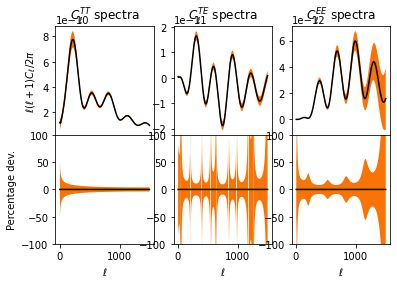

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:839: RuntimeWarning: invalid value encountered in double_scalars


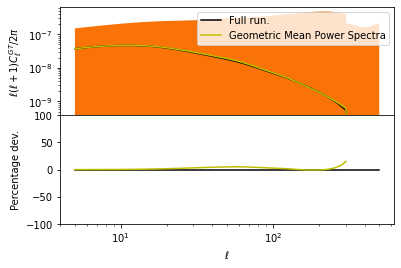

In [2]:
#%%
########
# Main #
########

#####################
# FORECAST ANALYSIS #
#####################


# Initialise ell array
ellArray = np.array([])
for i in range(5, 1501):
    ellArray = np.append(ellArray, [i])

ellArrayCMBLens = np.array([])
for i in range(5, 2001):
    ellArrayCMBLens = np.append(ellArrayCMBLens, [i])
ellArrayISW = np.array([])
for i in range(5, 501):
    ellArrayISW = np.append(ellArrayISW, [i])

ellArrayCMB = np.array([])
for i in range(5, 1501):
    ellArrayCMB = np.append(ellArrayCMB, [i])


# Initialise instruments
thetaBeam = np.array([33, 23, 14, 9.5, 7.1, 5.0, 5.0, 5.0, 5.0])
sigmaT = np.array([4.4e-6, 6.5e-6, 9.8e-6, 6.8e-6, 6.0e-6, 13.1e-6, 40.1e-6, 401e-6, 18300e-6])
sigmaP = np.array([6.2e-6, 9.2e-6, 13.9e-6, 10.9e-6, 11.4e-6, 26.7e-6, 81.2e-6, 100000000, 100000000])
CMB = CMBInstrument(fSky=0.65, thetaBeam=thetaBeam, sigmaT=sigmaT, sigmaP=sigmaP)
CMBEMode = CMBInstrumentEMode(fSky=0.65, thetaBeam=thetaBeam, sigmaT=sigmaT, sigmaP=sigmaP)

# 4MOST GC Bins
gal1 = GalaxyInstrument(fSky=0.1818, galNumber=250, galName="4MOST1")
gal2 = GalaxyInstrument(fSky=0.1818, galNumber=400, galName="4MOST2")
gal3 = GalaxyInstrument(fSky=0.02424, galNumber=1200, galName="4MOST3")
gal4 = GalaxyInstrument(fSky=0.1818, galNumber=190, galName="4MOST4")
gal5 = GalaxyInstrument(fSky=0.1818, galNumber=50, galName="4MOST5")
galInstruments=[gal1, gal2, gal3, gal4, gal5]
## DES Y3 Bins      (Same specs used for Toy Model)
#gal1 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.154*60*60, galName="DES1")
#gal2 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.115*60*60, galName="DES2")
#gal3 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.115*60*60, galName="DES3")
#gal4 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.154*60*60, galName="DES4")
#gal5 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.117*60*60, galName="DES5")
#gal6 = GalaxyInstrument(fSky=0.1818*(4946/7500), galNumber=0.113*60*60, galName="DES6")
#galInstruments=[gal1, gal2, gal3, gal4, gal5, gal6]

# Y3
lens1 = LensingInstrument(fSky=0.1818*(4143/7500), galNumber=1.48, galName="DES1", sigmae=0.24)
lens2 = LensingInstrument(fSky=0.1818*(4143/7500), galNumber=1.48, galName="DES2", sigmae=0.26)
lens3 = LensingInstrument(fSky=0.1818*(4143/7500), galNumber=1.48, galName="DES3", sigmae=0.26)
lens4 = LensingInstrument(fSky=0.1818*(4143/7500), galNumber=1.46, galName="DES4", sigmae=0.30)

lenseInstruments=[lens1, lens2, lens3, lens4]


# Initialise parameters
devMult = 1.0  # As defined in 4MOSTForecastInput.ipynb
h=0.6766
As=2.105*(10**-9.)
ns=0.9665
omegaM=0.3111
omegaB=0.02242/(0.6766*0.6766)
fnu=0.12/(93.14*0.3111*0.6766*0.6766)
Neff=3.046
tau=0.0561
w0=-1
wa=0
logT_AGN=7.8

# 4MOST
b0=1.285
c0=1.0
alpha0=1.0
b1=1.549
c1=1.0
alpha1=1.0
b2=1.488
c2=1.0
alpha2=1.0
b3=1.349
c3=1.0
alpha3=1.0
b4=1.349
c4=1.0
alpha4=1.0
numDen0=250
numDen1=400
numDen2=1200
numDen3=190
numDen4=50

## DES
#b0=1.5
#b1=1.8
#b2=1.8
#b3=1.9
#b4=2.3
#b5=2.3
#sigmab0=0.05
#sigmab1=0.05
#sigmab2=0.05
#sigmab3=0.05
#sigmab4=0.05
#sigmab5=0.05
##sigmab0=0.01
##sigmab1=0.01
##sigmab2=0.01
##sigmab3=0.01
##sigmab4=0.01
##sigmab5=0.01
#cb0=1.0
#cb1=1.0
#cb2=1.0
#cb3=1.0
#cb4=1.0
#cb5=1.0
#numDen0=0.154*60*60
#numDen1=0.115*60*60
#numDen2=0.115*60*60
#numDen3=0.154*60*60
#numDen4=0.117*60*60
#numDen5=0.113*60*60

hDev=devMult*0.01
AsDev=devMult*0.1*(10**-9.)
nsDev=devMult*0.1
omegaMDev=devMult*0.01
omegaBDev=devMult*0.001/(0.6766*0.6766)
fnuDev=devMult*0.05/(93.14*0.3111*0.6766*0.6766)
NeffDev=0.1
tauDev=0.05
w0Dev=devMult*0.1
waDev=devMult*0.1
logT_AGNDev=devMult*logT_AGN/10

b0Dev=b0/10.0                    # In 4MOST and DES
b1Dev=b1/10.0
b2Dev=b2/10.0
b3Dev=b3/10.0
b4Dev=b4/10.0
numDenDev0=(numDen0/10.0)/numDen0
numDenDev1=(numDen1/10.0)/numDen1
numDenDev2=(numDen2/10.0)/numDen2
numDenDev3=(numDen3/10.0)/numDen3
numDenDev4=(numDen4/10.0)/numDen4
## DES
#b5Dev=devMult*b5/10.0
#sigmab0Dev=devMult*sigmab0/10.0
#sigmab1Dev=devMult*sigmab1/10.0
#sigmab2Dev=devMult*sigmab2/10.0
#sigmab3Dev=devMult*sigmab3/10.0
#sigmab4Dev=devMult*sigmab4/10.0
#sigmab5Dev=devMult*sigmab5/10.0
#cb0Dev=devMult*cb0/10.0
#cb1Dev=devMult*cb1/10.0
#cb2Dev=devMult*cb2/10.0
#cb3Dev=devMult*cb3/10.0
#cb4Dev=devMult*cb4/10.0
#cb5Dev=devMult*cb5/10.0
#numDenDev5=(numDen5/10.0)/numDen5

AIA = 1.0
AIADev = devMult*AIA/10.0
etaIA = 0.0
etaIADev = devMult*0.1
mag = 1.0
Ssigmab0=0.05
Ssigmab1=0.05
Ssigmab2=0.05
Ssigmab3=0.05
magDev = 1.0
shearm = 0.0
shearmDev = 0.001
Ssigmab0Dev=devMult*Ssigmab0/10.0
Ssigmab1Dev=devMult*Ssigmab1/10.0
Ssigmab2Dev=devMult*Ssigmab2/10.0
Ssigmab3Dev=devMult*Ssigmab3/10.0


In [12]:
# Jacobians
# Note: sigma_8 (or S8) Jacobians require production of sigma_8 derivatives. See cell below if not already made.

def s8Jacobian(Jacobian, s8Indx, sigma8):
    s8Jac = np.copy(Jacobian)
    for i in range(len(s8Jac)):
        if(i==s8Indx):
            for j in range(len(sigma8)-1):
                s8Jac[i][j] = sigma8[j+1]
    return s8Jac

h=0.6766
As=1.0
ns=0.9665
omegaM=0.3111
OmegaB=0.02242/(0.6766*0.6766)
omegaB=0.02242
fnu=0.12/(93.14*0.3111*0.6766*0.6766)
Neff=3.046
tau=0.0561
w0=-1
wa=0
OmC = omegaM - omegaB - (fnu*omegaM*h*h)
Mnu=93.14*fnu*omegaM*h*h

# nuwCDM Jacobian
# h, OmB, OmM, fnu, As, ns, Neff, tau, w0, wa
# wc, wb, OmM, mnu, As, ns, Neff, tau, w0, wa
nuwCDMJac = np.array([[2*h*OmC,		  -h*h,   h*h*(1-fnu),      -omegaM*h*h, 0, 0, 0, 0, 0, 0],
                        [2*h*OmegaB,	   h*h,             0, 		  	   	  0, 0, 0, 0, 0, 0, 0],
                        [0,				 0,             1, 		  	      0, 0, 0, 0, 0, 0, 0],
                        [2*93.14*fnu*h*omegaM, 0, 93.14*fnu*h*h, 93.14*omegaM*h*h, 0, 0, 0, 0, 0, 0],
                        [0,				 0,           	0,		      	  0, 1, 0, 0, 0, 0, 0],
                        [0,				 0,           	0,		      	  0, 0, 1, 0, 0, 0, 0],
                        [0,          		 0,           	0,		      	  0, 0, 0, 1, 0, 0, 0],
                        [0,          		 0,           	0,		      	  0, 0, 0, 0, 1, 0, 0],
                        [0,          		 0,           	0,		      	  0, 0, 0, 0, 0, 1, 0],
                        [0,          		 0,           	0,		      	  0, 0, 0, 0, 0, 0, 1]])
nuwCDMS8Indx = 4
nuwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8nuwCDM.dat')
nuwCDMJacS8 = s8Jacobian(Jacobian=nuwCDMJac, s8Indx=nuwCDMS8Indx, sigma8=nuwCDMS8)
# wCDM Jacobian
# h, OmB, OmM, As, ns, tau, w0, wa
# wc, wb, OmM, As, ns, tau, w0, wa
wCDMJac = np.array([[2*h*OmC,		  -h*h,   h*h*(1-fnu),	0, 0, 0, 0, 0],
                    [2*h*OmegaB,	   h*h,             0, 	0, 0, 0, 0, 0],
                    [0,				 0,             1, 	0, 0, 0, 0, 0],
                    [0,				 0,           	0,	1, 0, 0, 0, 0],
                    [0,				 0,           	0,	0, 1, 0, 0, 0],
                    [0,          		 0,           	0,	0, 0, 1, 0, 0],
                    [0,          		 0,           	0,	0, 0, 0, 1, 0],
                    [0,          		 0,           	0,	0, 0, 0, 0, 1]])
wCDMS8Indx = 3
wCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8wCDM.dat')
wCDMJacS8 = s8Jacobian(Jacobian=wCDMJac, s8Indx=wCDMS8Indx, sigma8=wCDMS8)
# nuLCDM Jacobian
# h, OmB, OmM, fnu, As, ns, Neff, tau
# wc, wb, OmM, mnu, As, ns, Neff, tau
nuLCDMJac = np.array([[2*h*OmC,		  -h*h,   h*h*(1-fnu),      -omegaM*h*h, 0, 0, 0, 0],
                    [2*h*OmegaB,	   h*h,             0, 		  	   	  0, 0, 0, 0, 0],
                    [0,				 0,             1, 		  	      0, 0, 0, 0, 0],
                    [2*93.14*fnu*h*omegaM, 0, 93.14*fnu*h*h, 93.14*omegaM*h*h, 0, 0, 0, 0],
                    [0,				 0,           	0,		      	  0, 1, 0, 0, 0],
                    [0,				 0,           	0,		      	  0, 0, 1, 0, 0],
                    [0,          		 0,           	0,		      	  0, 0, 0, 1, 0],
                    [0,          		 0,           	0,		      	  0, 0, 0, 0, 1]])
nuLCDMS8Indx = 4
nuLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8nuLCDM.dat')
nuLCDMJacS8 = s8Jacobian(Jacobian=nuLCDMJac, s8Indx=nuLCDMS8Indx, sigma8=nuLCDMS8)
# LCDM Jacobian
# h, OmB, OmM, As, ns, tau
# wc, wb, OmM, As, ns, tau
LCDMJac = np.array([[2*h*OmC,		  -h*h,   h*h*(1-fnu),	0, 0, 0],
                    [2*h*OmegaB,	   h*h,             0, 	0, 0, 0],
                    [0,					 0,             1, 	0, 0, 0],
                    [0,					 0,           	0,	1, 0, 0],
                    [0,					 0,           	0,	0, 1, 0],
                    [0,          		 0,           	0,	0, 0, 1]])
LCDMS8Indx = 3
LCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8LCDM.dat')
LCDMJacS8 = s8Jacobian(Jacobian=LCDMJac, s8Indx=LCDMS8Indx, sigma8=LCDMS8)
# DES nuwCDM Jacobian
# h, OmB, OmM, fnu, As, ns, w0
# h, OmB, OmM, mnu, As, ns, w0
DESnuwCDMJac = np.array([[1,		  0,   0,      0, 0, 0, 0],
                        [0,	   1,             0, 		  	   	  0, 0, 0, 0],
                        [0,				 0,             1, 		  	      0, 0, 0, 0],
                        [2*93.14*fnu*h*omegaM, 0, 93.14*fnu*h*h, 93.14*omegaM*h*h, 0, 0, 0],
                        [0,				 0,           	0,		      	  0, 1, 0, 0],
                        [0,				 0,           	0,		      	  0, 0, 1, 0],
                        [0,          		 0,           	0,		      	  0, 0, 0, 1]])
DESnuwCDMS8Indx = 4
DESnuwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DESnuwCDM.dat')
DESnuwCDMJacS8 = s8Jacobian(Jacobian=DESnuwCDMJac, s8Indx=DESnuwCDMS8Indx, sigma8=DESnuwCDMS8)
# DES nuLCDM Jacobian
# h, OmB, OmM, fnu, As, ns
# h, OmB, OmM, mnu, As, ns
DESnuLCDMJac = np.array([[1,		  0,   0,      0, 0, 0],
                        [0,	   1,             0, 		  	   	  0, 0, 0],
                        [0,				 0,             1, 		  	      0, 0, 0],
                        [2*93.14*fnu*h*omegaM, 0, 93.14*fnu*h*h, 93.14*omegaM*h*h, 0, 0],
                        [0,				 0,           	0,		      	  0, 1, 0],
                        [0,				 0,           	0,		      	  0, 0, 1]])
DESnuLCDMS8Indx = 4
DESnuLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DESnuLCDM.dat')
DESnuLCDMJacS8 = s8Jacobian(Jacobian=DESnuLCDMJac, s8Indx=DESnuLCDMS8Indx, sigma8=DESnuLCDMS8)
# DES 3x2pt wCDM Jacobian
# OmM, As, w
# OmM, As, w
DES3x2ptwCDMJac = np.array([[1., 0, 0],
                            [0, 1., 0],
                            [0, 0, 1.]])
DES3x2ptwCDMS8Indx = 1
DES3x2ptwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DES3x2ptwCDM.dat')
DES3x2ptwCDMJacS8 = s8Jacobian(Jacobian=DES3x2ptwCDMJac, s8Indx=DES3x2ptwCDMS8Indx, sigma8=DES3x2ptwCDMS8)
# DES 3x2pt LCDM Jacobian
# OmM, As
# OmM, As
DES3x2ptLCDMJac = np.array([[1., 0],
                            [0, 1.]])
DES3x2ptLCDMS8Indx = 1
DES3x2ptLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DES3x2ptLCDM.dat')
DES3x2ptLCDMJacS8 = s8Jacobian(Jacobian=DES3x2ptLCDMJac, s8Indx=DES3x2ptLCDMS8Indx, sigma8=DES3x2ptLCDMS8)
print(DES3x2ptLCDMS8)

# Reset parameters (like As)

h=0.6766
As=2.105*(10**-9.)
ns=0.9665
omegaM=0.3111
omegaB=0.02242/(0.6766*0.6766)
fnu=0.12/(93.14*0.3111*0.6766*0.6766)
Neff=3.046
tau=0.0561
w0=-1
wa=0
logT_AGN=7.8

# Set Jacobians
JacobianS8 = nuwCDMJacS8
Jacobian = nuwCDMJac


[0.79724777 1.90385134 0.39873645]


In [13]:
#######################
#### FULL FORECAST ####
#######################

print("Starting forecast.")

# Planck

# DES Comparison nuLCDM
#PlanckparamNames = np.array(["h","OmB","OmM","fnu","As","ns"])
#PlanckparamValues = np.array([h, omegaB, omegaM, fnu, As, ns])
#PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev])
# DES Comparison nuwCDM
#PlanckparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0"])
#PlanckparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0])
#PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev])
# DES 3x2pt wCDM
#PlanckparamNames = np.array(["OmM","As","w0"])
#PlanckparamValues = np.array([omegaM, As, w0])
#PlanckparamDevs = np.array([omegaMDev,AsDev/As,w0Dev])
# DES 3x2pt LCDM
#PlanckparamNames = np.array(["OmM","As"])
#PlanckparamValues = np.array([omegaM, As])
#PlanckparamDevs = np.array([omegaMDev,AsDev/As])
# nuwCDM
PlanckparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa"])
PlanckparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa])
PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev])
# LCDM
#PlanckparamNames = np.array(["h","OmB","OmM","As","ns","tau"])
#PlanckparamValues = np.array([h, omegaB, omegaM, As, ns, tau])
#PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev])
# wCDM
#PlanckparamNames = np.array(["h","OmB","OmM","As","ns","tau","w0","wa"])
#PlanckparamValues = np.array([h, omegaB, omegaM, As, ns, tau, w0, wa])
#PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,w0Dev,waDev])
# nuLCDM
#PlanckparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau"])
#PlanckparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau])
#PlanckparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev])



CMBparamNames = np.array(["h","OmB","OmM","fnu","Neff","As","ns","tau","w0","wa"])
CMBparamValues = np.array([h, omegaB, omegaM, fnu, Neff, As, ns, tau, w0, wa])
translationToCAMB = np.array([0,5,6,2,1,3,4,7,8,9])
cambParamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,NeffDev,AsDev,nsDev,tauDev,w0Dev,waDev])
PlanckObservables = {"CMB":True, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
PlanckModel = FullForecast(observables=PlanckObservables, paramNames=PlanckparamNames, paramValues=PlanckparamValues,
                           paramDevs=PlanckparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
                           galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
                           CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
                           translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
                           hierarchy="normal", suffix="Growth")
s8Array = PlanckModel.sigma8Derivative()  # Note this is required for Jacobians in cell above, ONLY.
#np.savetxt(FILEPATH + '/InputFiles/TestingFiles/sigma8nuwCDM.dat', s8Array)
print("Finished sigma_8")
FisherCMB = FisherMatrix(Model=PlanckModel)
FisherPlanckOrig = FisherCMB.generateFisher(condNum=True, subMatrix=True, subMatrixLen=3, plotCovarMat=False, plotSubCovar=False)

# Fisher matrix transformation
#JacS8 = np.identity(len(FisherPlanckOrig))     # For untransformed Fisher matrices
#Jac = np.identity(len(FisherPlanckOrig))
JacS8 = JacobianS8
Jac = Jacobian
FisherPlanck = FisherCMB.transformFisher(jacobian=Jac, fisherMatrix=FisherPlanckOrig)
FisherPlanckS8 = FisherCMB.transformFisher(jacobian=JacS8, fisherMatrix=FisherPlanckOrig)

#PlanckMeanSpectra = PlanckModel.returnMeanData()
#CMBSignalToNoise = FisherCMB.signalToNoise(meanSpectra=PlanckMeanSpectra, ellArray=ellArrayCMB)

# Planck Extended
ellArrayCMBSmallScale = np.array([])
for i in range(1501, 2001):
	ellArrayCMBSmallScale = np.append(ellArrayCMBSmallScale, [i])
PlanckObservables = {"CMB":True, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
PlanckModelExt = FullForecast(observables=PlanckObservables, paramNames=PlanckparamNames, paramValues=PlanckparamValues, 
                              paramDevs=PlanckparamDevs, ellArray=ellArrayCMBSmallScale, lenseInstruments=lenseInstruments, 
                              galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMBSmallScale, 
                              CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues, 
                              translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs, 
                              hierarchy="normal", suffix="Growth")
FisherCMBExt = FisherMatrix(Model=PlanckModelExt)
FisherPlanckExtOrig = FisherCMBExt.generateFisher(condNum=True, subMatrix=True, subMatrixLen=3, plotCovarMat=False)
# Fisher matrix transformation
#JacS8 = np.identity(len(FisherPlanck))     # For untransformed Fisher matrices
#Jac = np.identity(len(FisherPlanck))
JacS8 = JacobianS8
Jac = Jacobian
FisherPlanckExt = FisherCMBExt.transformFisher(jacobian=Jac, fisherMatrix=FisherPlanckExtOrig)
FisherPlanckExtS8 = FisherCMBExt.transformFisher(jacobian=JacS8, fisherMatrix=FisherPlanckExtOrig)

print("CMB Done.")

FisherMatPlanck = FisherPlanck+FisherPlanckExt
FisherMatPlanckS8 = FisherPlanckS8+FisherPlanckExtS8

print(np.linalg.cond(FisherMatPlanck, 'fro'))


Starting forecast.
Finished sigma_8
[['T', 'T'], ['T', 'E'], ['E', 'E']]
Mean derivatives done.
Generated covariance in: 1.6505742073059082 seconds.
Covariance done.
Generated mean deviation and covariance in: 82.57248520851135 seconds.
10
Generating Fisher...
[[ 1.00000000e+00 -2.28595808e-11 -2.47448383e-10 -3.22846284e-11
   2.71628841e-12 -2.06564459e-12 -4.69385301e-11  1.07639522e-12
   4.17376273e-11 -1.05957452e-09]
 [ 4.15715748e-11  1.00000000e+00 -1.80947195e-10 -2.93720942e-11
   3.38377818e-12 -4.55741227e-13 -9.67193872e-11  7.11141917e-13
   1.97383842e-11 -4.33368613e-09]
 [-3.71116779e-14 -6.70239045e-12  1.00000000e+00 -8.90177698e-12
  -4.69501804e-14 -1.69570573e-13  1.38437461e-11 -7.37962336e-13
  -2.04253021e-11 -3.45166789e-10]
 [ 1.77417058e-11 -2.62319582e-12 -2.47167395e-11  1.00000000e+00
  -1.87476840e-13  8.10578819e-14  7.20503032e-12 -5.12374600e-15
  -1.52906271e-12 -2.20065965e-10]
 [ 4.29651127e-11 -3.24538310e-12 -2.72165446e-11 -4.09383384e-12
   1.

In [14]:
# Redefine correlation plotters


def set_pub():      # Set publication graph features
    plt.rcParams.update({
        "font.size": 20,        # font size
        "figure.figsize":(9, 8),# figure size
        "lines.linewidth": 2,
        "font.weight": "bold",  # bold fonts
        "text.usetex": True,
        "font.family": 'serif'
    })
set_pub()

def collectionCorrelationPlotter(corrs, labelLimits, labelNames, colors, title="", cmap="Blues"):
    fig = plt.figure(figsize=(12,8))  # Deviate from publication as unique plot
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    axs = []
    axs.append(fig.add_subplot(2,3,1))
    axs.append(fig.add_subplot(2,3,2))
    axs.append(fig.add_subplot(1,3,3))
    axs.append(fig.add_subplot(2,3,4))
    axs.append(fig.add_subplot(2,3,5))
    # Plot each sub-correlation matrix
    im = subCorrelationPlotter(ax=axs[0], corr=corrs[0], labelLimits=labelLimits, colors=colors, cmap=cmap, labelLeft=True)
    im = subCorrelationPlotter(ax=axs[1], corr=corrs[1], labelLimits=labelLimits, colors=colors, cmap=cmap)
    im = subCorrelationPlotter(ax=axs[3], corr=corrs[2], labelLimits=labelLimits, colors=colors, cmap=cmap, labelLeft=True, labelBottom=True)
    im = subCorrelationPlotter(ax=axs[4], corr=corrs[3], labelLimits=labelLimits, colors=colors, cmap=cmap, labelBottom=True)
    patchList = []
    for i in range(len(labelNames)):
        patchList.append(mpatches.Patch(color=colors[i], label=labelNames[i]))
    # Sets colorbar on the RHS
    axs[2].legend(handles=patchList, loc='center', prop={'size': 20})
    axs[2].axis('off')
    divider = make_axes_locatable(axs[2])
    axcb = divider.append_axes("left", size="10%", pad=1.0)
    cb = fig.colorbar(im, ticks=[-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0], cax=axcb)
    cb.ax.tick_params(labelsize=20)
    plt.savefig(FILEPATH + "/Graphs/CovarianceMatrix550100200.png")
    plt.show()

def subCorrelationPlotter(ax, corr, labelLimits, colors, cmap="Blues", labelLeft=False, labelBottom=False):
    labels = labelLimits
    im = ax.imshow(corr, cmap=cmap, vmin=-1, vmax=1)
    print("Correlation shape:")
    print(corr.shape)
    tickArr = np.zeros(len(labelLimits))
    for i in range(len(labelLimits)):
        tickArr[i] = labelLimits[i][0]-0.5
    ax.set_xticks(tickArr)
    ax.set_yticks(tickArr)
    ax.grid(which='major', color='k', linestyle='--', linewidth=1)
    ax.tick_params(which='major', bottom=False, left=False)
    # create axes next to plot
    divider = make_axes_locatable(ax)
    # plot colored bar plots to the axes
    barkw = dict( color=colors, linewidth=0.72, ec="k", clip_on=False, align='edge',)
    if(labelBottom):
        axb = divider.append_axes("bottom", "10%", pad=0.06, sharex=ax)
        axb.invert_yaxis()
        axb.axis("off")
        axb.bar(labels[:,0]-0.5,np.ones(len(labels)), width=np.diff(labels, axis=1).flatten(), **barkw)
    else:
        axb = divider.append_axes("bottom", "10%", pad=0.06, sharex=ax)
        axb.axis("off")
    if(labelLeft):
        axl = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
        axl.invert_xaxis()
        axl.axis("off")
        axl.barh(labels[:,0]-0.5,np.ones(len(labels)), height=np.diff(labels, axis=1).flatten(), **barkw)
    else:
        axl = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
        axl.axis("off")

    # set margins to zero again
    ax.margins(0)
    ax.tick_params(axis="both", bottom=0, left=0, labelbottom=0,labelleft=0)

    return im



In [15]:
# All observables

### LCDM ###
#Con
#FullparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#Int
#FullparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","b3","b4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, b3, b4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### wCDM ###
#Con
#FullparamNames = np.array(["h","OmB","OmM","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, As, ns, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### nuLCDM ###
#Con
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### nuwCDM ###
#Con
FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#Int
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES Comparison nuLCDM ###
#4MOST
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#DES
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, numDen0, numDen1, numDen2, numDen3, numDen4, numDen5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,numDenDev5,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES Comparison nuwCDM ###
#4MOST
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#DES
#FullparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#FullparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, numDen0, numDen1, numDen2, numDen3, numDen4, numDen5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#FullparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,numDenDev5,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])

fullObservables = {"CMB":True, "CMBLens":False, "ISW":True, "Gal-Gal":True, "Lens-Lens":True, "Gal-Gal Lens":True, "CMBLens-Lens":False}
FullModel = FullForecast(observables=fullObservables, paramNames=FullparamNames, paramValues=FullparamValues,
							paramDevs=FullparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="Growth")
FisherFull = FisherMatrix(Model=FullModel)



[['T', 'T'], ['T', 'E'], ['E', 'E'], ['T', 'g0'], ['T', 'g1'], ['T', 'g2'], ['T', 'g3'], ['T', 'g4'], ['g0', 'g0'], ['g1', 'g1'], ['g1', 'g2'], ['g2', 'g2'], ['g2', 'g3'], ['g3', 'g3'], ['g4', 'g4'], ['g0', 'L1'], ['g0', 'L2'], ['g0', 'L3'], ['g1', 'L2'], ['g1', 'L3'], ['g2', 'L3'], ['L0', 'L0'], ['L0', 'L1'], ['L0', 'L2'], ['L0', 'L3'], ['L1', 'L1'], ['L1', 'L2'], ['L1', 'L3'], ['L2', 'L2'], ['L2', 'L3'], ['L3', 'L3']]
Mean derivatives done.
Generated covariance in: 18.300079345703125 seconds.
Covariance done.
Generated mean deviation and covariance in: 169.214515209198 seconds.
33


Generating Fisher...
5
(31, 31)
(33, 31)


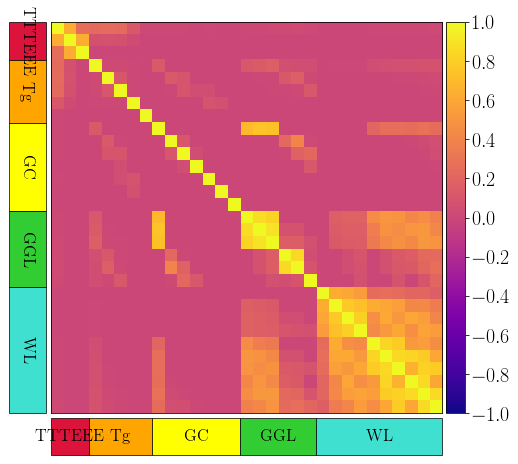

50
(31, 31)
(33, 31)


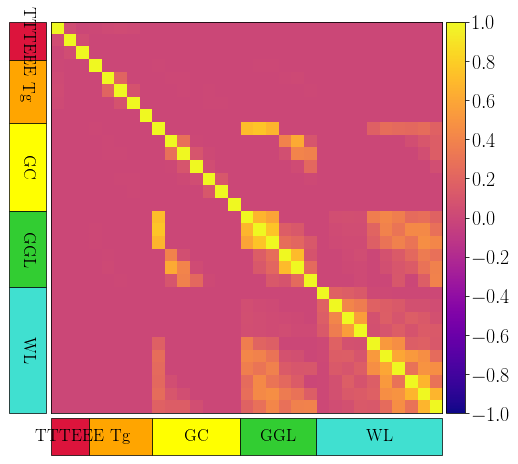

100
(31, 31)
(33, 31)


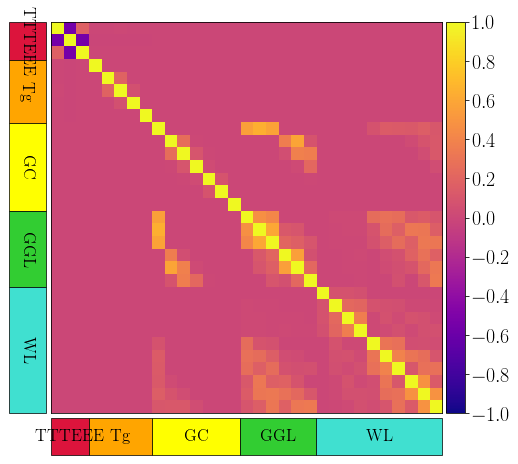

200
(31, 31)
(33, 31)


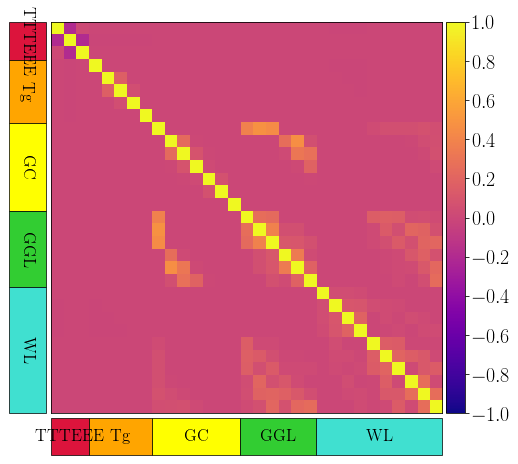

[[ 1.00000000e+00 -1.13289160e-13 -8.67920239e-13 ...  1.25321032e-12
   2.18362587e-13 -4.52745500e-13]
 [ 2.52915423e-12  1.00000000e+00 -2.54679195e-12 ... -1.70097665e-12
   1.15867328e-12 -8.76311229e-14]
 [-1.39364125e-12 -4.05514427e-14  1.00000000e+00 ...  6.96225251e-13
  -2.10931360e-13 -1.72465672e-13]
 ...
 [-7.34380352e-15  6.33951705e-16  1.38221693e-15 ...  1.00000000e+00
  -6.14467978e-15 -8.24278767e-15]
 [-1.40112490e-14  1.29233387e-15  9.86353201e-15 ...  6.10236033e-16
   1.00000000e+00 -4.69229038e-15]
 [-6.66553920e-15  1.37063703e-16 -1.58933678e-14 ... -2.93153694e-14
  -1.06194544e-14  1.00000000e+00]]
Highest condition number:
204.6002587281223
Correlation shape:
(31, 31)
Correlation shape:
(31, 31)
Correlation shape:
(31, 31)
Correlation shape:
(31, 31)


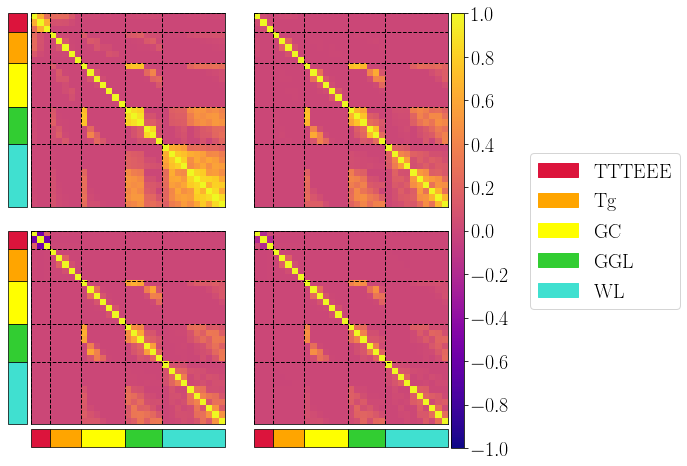

Full Fisher condition number:
604028053356.9143
Full Correlation Fisher condition number:
157052.57266335827


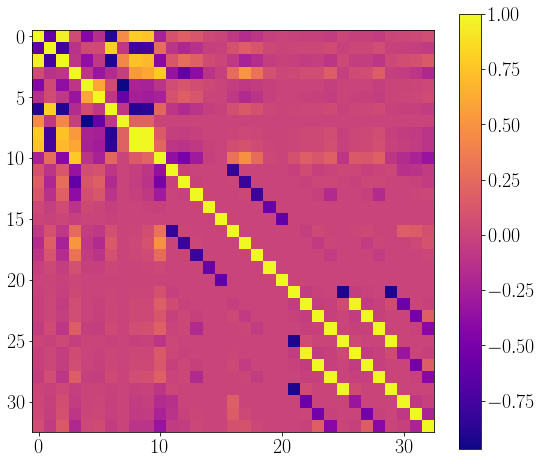

Inverting...
103939.20276333093
Re-inverting...
64080.480023885015
Inverting...
341193.9535976254
Re-inverting...
220435.95511495566
10
Full forecast done.


In [16]:
#%%
FullDataLen = len(FisherFull.meanDevArray[0])
FisherMatFullOrig = FisherFull.generateFisher(condNum=True, subMatrix=True, subMatrixLen=round(FullDataLen/len(ellArray)), plotCovarMat=False, plotSubCovar=True)
print("Full Fisher condition number:")
print(np.linalg.cond(FisherMatFullOrig, 'fro'))
fisherFullMatrices = [FisherMatFullOrig]
variance = np.zeros((len(FisherMatFullOrig)))
for i in range(len(FisherMatFullOrig)):
    variance[i] = FisherMatFullOrig[i][i]**0.5
FisherMatFullCorr = np.zeros(FisherMatFullOrig.shape)
for i in range(len(FisherMatFullOrig)):
    for j in range(len(FisherMatFullOrig)):
        FisherMatFullCorr[i][j] = FisherMatFullOrig[i][j]/(variance[i]*variance[j])
print("Full Correlation Fisher condition number:")
print(np.linalg.cond(FisherMatFullCorr, 'fro'))
plt.imshow(FisherMatFullCorr, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

# Marginalised parameter options (corresponds to parameter lists in above cells)
# LCDM
#marginalisedIndices = [28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
# nuLCDM/wCDM
#marginalisedIndices = [30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8]
# nuwCDM
marginalisedIndices = [32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10]
#marginalisedIndices = [27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10]
# DES nuLCDM
#marginalisedIndices = [28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
# DES nuwCDM
#marginalisedIndices = [29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]

# Fisher matrix transformation
JacS8 = np.identity(len(FisherMatFullOrig))
Jac = np.identity(len(FisherMatFullOrig))
JacS8[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = JacobianS8
Jac[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = Jacobian

FisherMatFullUnmargin = FisherFull.transformFisher(jacobian=Jac, fisherMatrix=FisherMatFullOrig)
FisherMatFullUnmarginS8 = FisherFull.transformFisher(jacobian=JacS8, fisherMatrix=FisherMatFullOrig)

FisherFullMat = FisherFull.marginaliseOverParameters(FisherMatrix=FisherMatFullUnmargin, paramIndices=marginalisedIndices)
FisherFullMatS8 = FisherFull.marginaliseOverParameters(FisherMatrix=FisherMatFullUnmarginS8, paramIndices=marginalisedIndices)

print(len(FisherFullMat))
print("Full forecast done.")



Copied covariance matrix
[['T', 'g0'], ['T', 'g1'], ['T', 'g2'], ['T', 'g3'], ['T', 'g4']]
Mean derivatives done.
Generated covariance in: 2.5008292198181152 seconds.
Covariance done.
Generated mean deviation and covariance in: 5.738813877105713 seconds.
2
Copied covariance matrix
[['g0', 'g0'], ['g1', 'g1'], ['g1', 'g2'], ['g2', 'g2'], ['g2', 'g3'], ['g3', 'g3'], ['g4', 'g4']]
Mean derivatives done.
Generated covariance in: 0.680462121963501 seconds.
Covariance done.
Generated mean deviation and covariance in: 3.8736915588378906 seconds.
2
Copied covariance matrix
[['L0', 'L0'], ['L0', 'L1'], ['L0', 'L2'], ['L0', 'L3'], ['L1', 'L1'], ['L1', 'L2'], ['L1', 'L3'], ['L2', 'L2'], ['L2', 'L3'], ['L3', 'L3']]
Mean derivatives done.
Generated covariance in: 1.433176040649414 seconds.
Covariance done.
Generated mean deviation and covariance in: 6.359112739562988 seconds.
2
Copied covariance matrix
[['g0', 'L1'], ['g0', 'L2'], ['g0', 'L3'], ['g1', 'L2'], ['g1', 'L3'], ['g2', 'L3']]
Mean derivat

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator


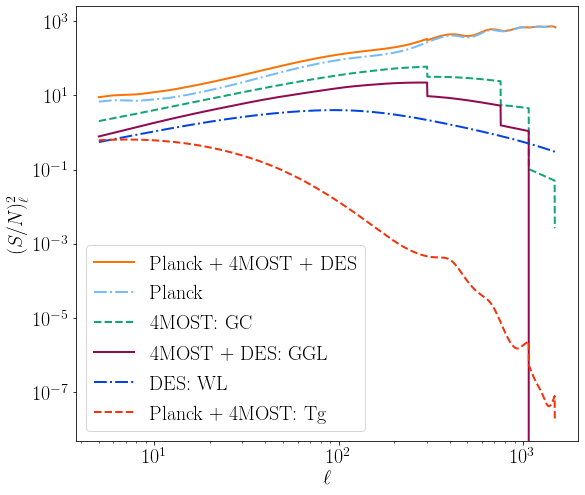

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator


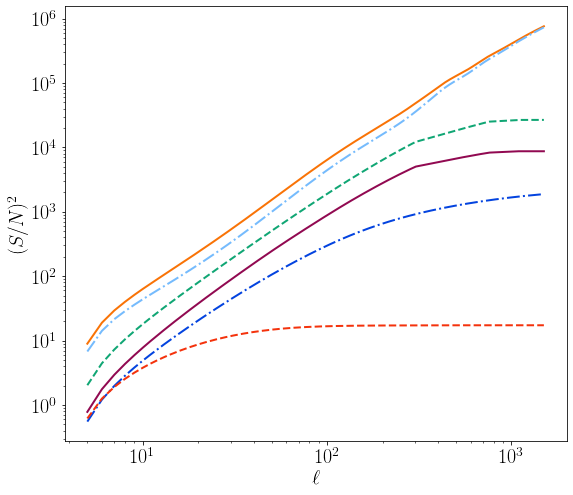

In [60]:
# Signal to Noise Graphs

FullMeanSpectra = FullModel.returnMeanData()
FullSignalToNoise = FisherFull.signalToNoise(meanSpectra=FullMeanSpectra, ellArray=ellArrayCMB)
GalaxyparamNames = np.array(["h","OmB"])
GalaxyparamValues = np.array([h, omegaB])
GalaxyparamDevs = np.array([hDev,omegaBDev])
GalaxyObservables = {"CMB":False, "CMBLens":False, "ISW":True, "Gal-Gal":False, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
GalaxyModel = FullForecast(observables=GalaxyObservables, paramNames=GalaxyparamNames, paramValues=GalaxyparamValues,
							paramDevs=GalaxyparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="")
FisherGalaxy = FisherMatrix(Model=GalaxyModel)
GalaxyMeanSpectra = GalaxyModel.returnMeanData()
ISWSignalToNoise = FisherGalaxy.signalToNoise(meanSpectra=GalaxyMeanSpectra, ellArray=ellArrayCMB)
GalaxyparamNames = np.array(["h","OmB"])
GalaxyparamValues = np.array([h, omegaB])
GalaxyparamDevs = np.array([hDev,omegaBDev])
GalaxyObservables = {"CMB":False, "CMBLens":False, "ISW":False, "Gal-Gal":True, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
GalaxyModel = FullForecast(observables=GalaxyObservables, paramNames=GalaxyparamNames, paramValues=GalaxyparamValues,
							paramDevs=GalaxyparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="")
FisherGalaxy = FisherMatrix(Model=GalaxyModel)
GalaxyMeanSpectra = GalaxyModel.returnMeanData()
GalaxySignalToNoise = FisherGalaxy.signalToNoise(meanSpectra=GalaxyMeanSpectra, ellArray=ellArrayCMB)
GalaxyparamNames = np.array(["h","OmB"])
GalaxyparamValues = np.array([h, omegaB])
GalaxyparamDevs = np.array([hDev,omegaBDev])
GalaxyObservables = {"CMB":False, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":True, "Gal-Gal Lens":False, "CMBLens-Lens":False}
GalaxyModel = FullForecast(observables=GalaxyObservables, paramNames=GalaxyparamNames, paramValues=GalaxyparamValues,
							paramDevs=GalaxyparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="")
FisherGalaxy = FisherMatrix(Model=GalaxyModel)
GalaxyMeanSpectra = GalaxyModel.returnMeanData()
WeakLensingSignalToNoise = FisherGalaxy.signalToNoise(meanSpectra=GalaxyMeanSpectra, ellArray=ellArrayCMB)
GalaxyparamNames = np.array(["h","OmB"])
GalaxyparamValues = np.array([h, omegaB])
GalaxyparamDevs = np.array([hDev,omegaBDev])
GalaxyObservables = {"CMB":False, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":False, "Gal-Gal Lens":True, "CMBLens-Lens":False}
GalaxyModel = FullForecast(observables=GalaxyObservables, paramNames=GalaxyparamNames, paramValues=GalaxyparamValues,
							paramDevs=GalaxyparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="")
FisherGalaxy = FisherMatrix(Model=GalaxyModel)
GalaxyMeanSpectra = GalaxyModel.returnMeanData()
GalaxyGalaxyLensingSignalToNoise = FisherGalaxy.signalToNoise(meanSpectra=GalaxyMeanSpectra, ellArray=ellArrayCMB)
GalaxyparamNames = np.array(["h","OmB"])
GalaxyparamValues = np.array([h, omegaB])
GalaxyparamDevs = np.array([hDev,omegaBDev])
GalaxyObservables = {"CMB":True, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
GalaxyModel = FullForecast(observables=GalaxyObservables, paramNames=GalaxyparamNames, paramValues=GalaxyparamValues,
							paramDevs=GalaxyparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments,
							galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB,
							CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues,
							translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs,
							hierarchy="normal", suffix="")
FisherGalaxy = FisherMatrix(Model=GalaxyModel)
GalaxyMeanSpectra = GalaxyModel.returnMeanData()
CMBSignalToNoise = FisherGalaxy.signalToNoise(meanSpectra=GalaxyMeanSpectra, ellArray=ellArrayCMB)
print("Retrieved signal to noise")
fig1, ax1 = plt.subplots(figsize=(9,8))
ax1.plot(ellArrayCMB, FullSignalToNoise, '-', label="Planck + 4MOST + DES")
ax1.plot(ellArrayCMB, CMBSignalToNoise, '-.', label="Planck")
ax1.plot(ellArrayCMB, GalaxySignalToNoise, '--', label="4MOST: GC")
ax1.plot(ellArrayCMB, GalaxyGalaxyLensingSignalToNoise, '-', label="4MOST + DES: GGL")
ax1.plot(ellArrayCMB, WeakLensingSignalToNoise, '-.', label="DES: WL")
ax1.plot(ellArrayCMB, ISWSignalToNoise, '--', label="Planck + 4MOST: Tg")
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_yticklabels(ax1.get_yticklabels())
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("$\ell$")
ax1.set_ylabel("$(S/N)^2_{\ell}$")
ax1.legend()
plt.savefig(FILEPATH + "/Graphs/SigToNoisePerEll.png")
plt.show()
fig2, ax2 = plt.subplots(figsize=(9,8))
ax2.plot(ellArrayCMB, np.cumsum(FullSignalToNoise), '-', label="Planck + 4MOST + DES")
ax2.plot(ellArrayCMB, np.cumsum(CMBSignalToNoise), '-.', label="Planck")
ax2.plot(ellArrayCMB, np.cumsum(GalaxySignalToNoise), '--', label="4MOST: GC")
ax2.plot(ellArrayCMB, np.cumsum(GalaxyGalaxyLensingSignalToNoise), '-', label="4MOST + DES: GGL")
ax2.plot(ellArrayCMB, np.cumsum(WeakLensingSignalToNoise), '-.', label="DES: WL")
ax2.plot(ellArrayCMB, np.cumsum(ISWSignalToNoise), '--', label="Planck + 4MOST: Tg")
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax2.set_xlabel("$\ell$")
ax2.set_ylabel("$(S/N)^2$")
ax2.set_yscale("log")
ax2.set_xscale("log")
plt.savefig(FILEPATH + "/Graphs/SigToNoiseCumulative.png")
plt.show()


[['T', 'T'], ['T', 'E'], ['E', 'E'], ['T', 'g0'], ['T', 'g1'], ['T', 'g2'], ['T', 'g3'], ['T', 'g4'], ['g0', 'g0'], ['g1', 'g1'], ['g1', 'g2'], ['g2', 'g2'], ['g2', 'g3'], ['g3', 'g3'], ['g4', 'g4']]
Mean derivatives done.
Generated covariance in: 8.969950437545776 seconds.
Covariance done.
Generated mean deviation and covariance in: 88.65014719963074 seconds.
21
Generating Fisher...
[[ 1.00000000e+00 -2.19736152e-12 -1.14387346e-11 -4.38362327e-12
   1.50848515e-12  6.66519218e-13  2.26231376e-11  9.31323293e-14
  -2.66019160e-11 -1.78970157e-11  2.10981915e-10 -3.33988136e-11
  -2.88397742e-11 -2.56318644e-11 -1.46435337e-11 -1.01994399e-11
  -4.21790154e-12 -1.92903704e-14 -7.29217785e-13  3.88761919e-14
  -5.18530043e-15]
 [-1.97161776e-11  1.00000000e+00  7.93186845e-12  3.95774180e-12
  -1.92583597e-12 -1.04723390e-12 -2.74738132e-11 -9.00517263e-14
   2.99090249e-11  4.37615329e-11  2.90093936e-11  2.45755469e-11
   3.04328661e-11  3.13335535e-11  9.66958377e-12  5.83640814e-12


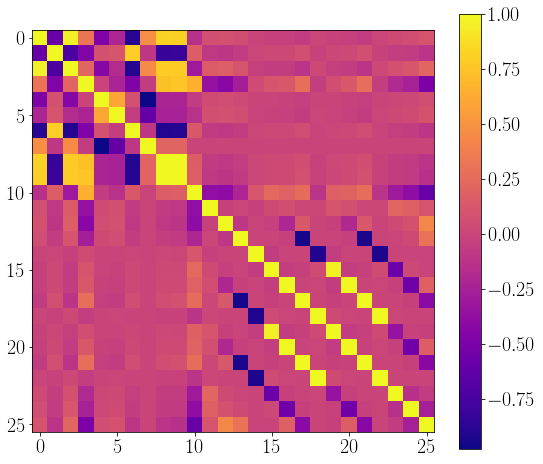

Lensing Fisher condition number:
18295170234190.4
Inverting...
2558325.1247469997
Re-inverting...
104817.41051781106
Inverting...
2692694.2910885136
Re-inverting...
492844.8836660476
Lensing done.
Models created.


In [17]:
#%%
# Rest of Fisher Plots


# Galaxies

### LCDM ###
#Con
#GalparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
#GalparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
#Int
#GalparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","b3","b4"])
#GalparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, b3, b4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev])
### wCDM ###
#GalparamNames = np.array(["h","OmB","OmM","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
#GalparamValues = np.array([h, omegaB, omegaM, As, ns, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
### nuLCDM ###
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
### nuwCDM ###
#Con
GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
#Int
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","b3","b4"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, b3, b4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev])
### DES Comparison nuLCDM ###
#4MOST
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
#DES
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, numDen0, numDen1, numDen2, numDen3, numDen4, numDen5])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,numDenDev5])
### DES Comparison nuwCDM ###
#4MOST
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","b3","b4","numDen0","numDen1","numDen2","numDen3","numDen4"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, b3, b4, numDen0, numDen1, numDen2, numDen3, numDen4])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4])
#DES
#GalparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","numDen0","numDen1","numDen2","numDen3","numDen4","numDen5"])
#GalparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, numDen0, numDen1, numDen2, numDen3, numDen4, numDen5])
#GalparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,numDenDev0,numDenDev1,numDenDev2,numDenDev3,numDenDev4,numDenDev5])

galObservables = {"CMB":True, "CMBLens":False, "ISW":True, "Gal-Gal":True, "Lens-Lens":False, "Gal-Gal Lens":False, "CMBLens-Lens":False}
GalModel = FullForecast(observables=galObservables, paramNames=GalparamNames, paramValues=GalparamValues, 
                        paramDevs=GalparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments, 
                        galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB, 
                        CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues, 
                        translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs, 
                        hierarchy="normal", suffix="Growth")
FisherGal = FisherMatrix(Model=GalModel)
GalDataLen = len(FisherGal.meanDevArray[0])
FisherMatGalOrig = FisherGal.generateFisher(condNum=True, subMatrix=True, subMatrixLen=round(GalDataLen/len(ellArray)), plotCovarMat=False, plotSubCovar=False)
variance = np.zeros((len(FisherMatGalOrig)))
for i in range(len(FisherMatGalOrig)):
	variance[i] = FisherMatGalOrig[i][i]**0.5
FisherMatGalCorr = np.zeros(FisherMatGalOrig.shape)
for i in range(len(FisherMatGalOrig)):
	for j in range(len(FisherMatGalOrig)):
		FisherMatGalCorr[i][j] = FisherMatGalOrig[i][j]/(variance[i]*variance[j])
print("Galaxy Correlation Fisher condition number:")
print(np.linalg.cond(FisherMatGalCorr, 'fro'))
print("Galaxy Fisher condition number:")
print(np.linalg.cond(FisherMatGalOrig, 'fro'))
fisherGalMatrices = [FisherMatGalOrig]
# Marginalised parameter options
# LCDM
#marginalisedIndices = [16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [11,10,9,8,7,6]
# nuLCDM/wCDM
#marginalisedIndices = [18,17,16,15,14,13,12,11,10,9,8]
# nuwCDM
marginalisedIndices = [20,19,18,17,16,15,14,13,12,11,10]
#marginalisedIndices = [15,14,13,12,11,10]
# DES nuLCDM
#marginalisedIndices = [16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
# DES nuwCDM
#marginalisedIndices = [17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]

# Fisher matrix transformation
JacS8 = np.identity(len(FisherMatGalOrig))
Jac = np.identity(len(FisherMatGalOrig))
JacS8[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = JacobianS8
Jac[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = Jacobian

FisherMatGalUnmargin = FisherGal.transformFisher(jacobian=Jac, fisherMatrix=FisherMatGalOrig)
FisherMatGalUnmarginS8 = FisherGal.transformFisher(jacobian=JacS8, fisherMatrix=FisherMatGalOrig)

FisherGalMat = FisherGal.marginaliseOverParameters(FisherMatrix=FisherMatGalUnmargin, paramIndices=marginalisedIndices)
FisherGalMatS8 = FisherGal.marginaliseOverParameters(FisherMatrix=FisherMatGalUnmarginS8, paramIndices=marginalisedIndices)

print("Galaxies Done.")



# Lensing

### LCDM ###
#Con
#LensparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#Int
#LensparamNames = np.array(["h","OmB","OmM","As","ns","tau","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, As, ns, tau, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### wCDM ###
#Con
#LensparamNames = np.array(["h","OmB","OmM","As","ns","tau","w0","wa","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, As, ns, tau, w0, wa, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,AsDev/As,nsDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### nuLCDM ###
#Con
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### nuwCDM ###
#Con
LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#Int
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","Neff","tau","w0","wa","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, Neff, tau, w0, wa, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,NeffDev,tauDev,w0Dev,waDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES Comparison nuLCDM ###
#4MOST
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#DES
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES Comparison nuwCDM ###
#4MOST
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#DES
#LensparamNames = np.array(["h","OmB","OmM","fnu","As","ns","w0","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([h, omegaB, omegaM, fnu, As, ns, w0, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([hDev,omegaBDev,omegaMDev,fnuDev,AsDev/As,nsDev,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])

lensObservables = {"CMB":True, "CMBLens":False, "ISW":False, "Gal-Gal":False, "Lens-Lens":True, "Gal-Gal Lens":True, "CMBLens-Lens":False}
lensModel = FullForecast(observables=lensObservables, paramNames=LensparamNames, paramValues=LensparamValues, 
                         paramDevs=LensparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments, 
                         galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB, 
                         CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues, 
                         translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs, 
                         hierarchy="normal", suffix="Growth")
FisherLens = FisherMatrix(Model=lensModel)
LensDataLen = len(FisherLens.meanDevArray[0])
FisherMatLensOrig = FisherLens.generateFisher(condNum=True, subMatrix=True, subMatrixLen=round(LensDataLen/len(ellArray)), plotCovarMat=False)
variance = np.zeros((len(FisherMatLensOrig)))
for i in range(len(FisherMatLensOrig)):
	variance[i] = FisherMatLensOrig[i][i]**0.5
FisherMatLensCorr = np.zeros(FisherMatLensOrig.shape)
for i in range(len(FisherMatLensOrig)):
	for j in range(len(FisherMatLensOrig)):
		FisherMatLensCorr[i][j] = FisherMatLensOrig[i][j]/(variance[i]*variance[j])
print("Lensing Correlation Fisher condition number:")
print(np.linalg.cond(FisherMatLensCorr, 'fro'))
plt.imshow(FisherMatLensCorr, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()
print("Lensing Fisher condition number:")
print(np.linalg.cond(FisherMatLensOrig, 'fro'))
fisherLensMatrices = [FisherMatLensOrig]
# Marginalised parameter options
# LCDM
#marginalisedIndices = [21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
# nuLCDM/wCDM
#marginalisedIndices = [23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8]
# nuwCDM
marginalisedIndices = [25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10]
#marginalisedIndices = [25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10]
# DES nuLCDM
#marginalisedIndices = [21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
#marginalisedIndices = [36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6]
# DES nuwCDM
#marginalisedIndices = [22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]
#marginalisedIndices = [37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7]

# Fisher matrix transformation
JacS8 = np.identity(len(FisherMatLensOrig))
Jac = np.identity(len(FisherMatLensOrig))
JacS8[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = JacobianS8
Jac[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = Jacobian

FisherMatLensUnmargin = FisherLens.transformFisher(jacobian=Jac, fisherMatrix=FisherMatLensOrig)
FisherMatLensUnmarginS8 = FisherLens.transformFisher(jacobian=JacS8, fisherMatrix=FisherMatLensOrig)

FisherLensMat = FisherLens.marginaliseOverParameters(FisherMatrix=FisherMatLensUnmargin, paramIndices=marginalisedIndices)
FisherLensMatS8 = FisherLens.marginaliseOverParameters(FisherMatrix=FisherMatLensUnmarginS8, paramIndices=marginalisedIndices)

print("Lensing done.")



print("Models created.")


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


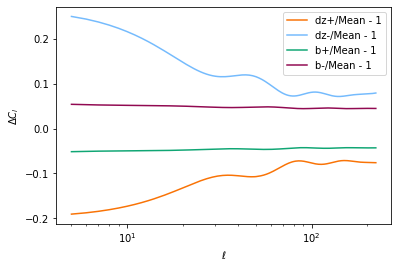

[['g0', 'g0'], ['g1', 'g1'], ['g1', 'g2'], ['g2', 'g2'], ['g2', 'g3'], ['g3', 'g3'], ['g4', 'g4'], ['g0', 'L1'], ['g0', 'L2'], ['g0', 'L3'], ['g1', 'L2'], ['g1', 'L3'], ['g2', 'L3'], ['L0', 'L0'], ['L0', 'L1'], ['L0', 'L2'], ['L0', 'L3'], ['L1', 'L1'], ['L1', 'L2'], ['L1', 'L3'], ['L2', 'L2'], ['L2', 'L3'], ['L3', 'L3']]
Mean derivatives done.
Generated covariance in: 6.760614633560181 seconds.
Covariance done.
Generated mean deviation and covariance in: 40.28927516937256 seconds.
21
[[-2.20620000e-04 -3.01650000e-05 -3.28555000e-06 ...  1.63798700e-09
   2.12943883e-09  3.47733435e-09]
 [ 8.17371500e-05  1.23195125e-05  6.46466550e-07 ...  1.61598745e-11
   2.31193508e-11  5.40281088e-11]
 [-4.42250000e-06  3.36200000e-06  2.43350000e-07 ... -1.18172850e-10
  -1.60211171e-10 -2.65937520e-10]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.60060460e-10
   1.79180913e-1

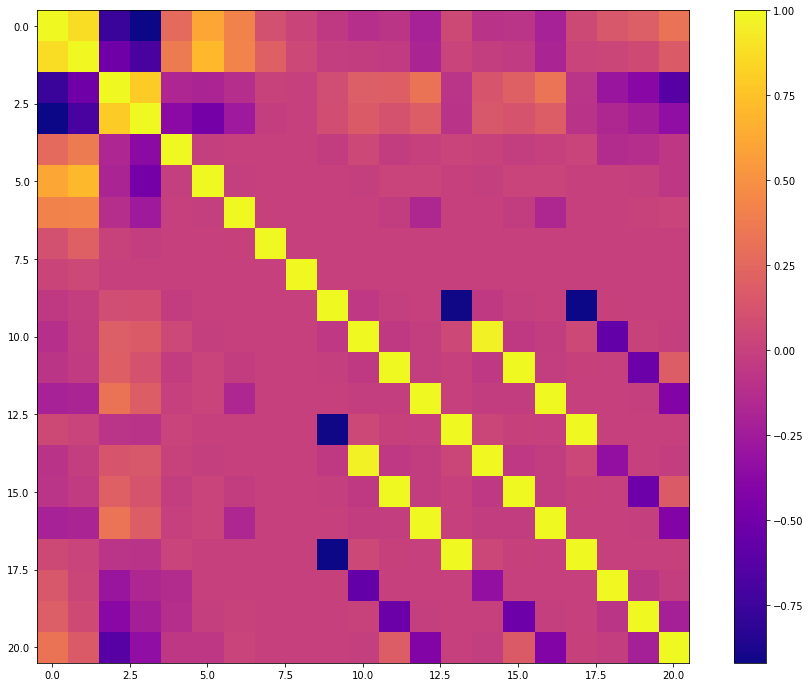

Galaxy Fisher condition number:
10217676340.308022
[[ 1.37646587e+06  1.40394048e+05 -5.75038588e+04 -9.06104512e+03
   4.31191108e+04  1.41777507e+05  6.23052532e+04  8.40280960e+03
   6.29453641e+02 -3.54784759e+02 -5.25691763e+02 -4.93502368e+02
  -5.19797574e+02  1.90336081e+01 -5.18342984e+01 -1.22624434e+02
  -2.01122177e+02  9.54201189e+02  9.33013482e+03  1.87480645e+04
   4.17583674e+04]
 [ 1.40394048e+05  1.86545693e+04 -4.51782215e+03 -7.96080319e+02
   7.04823343e+03  1.86105950e+04  7.40983102e+03  1.88340959e+03
   1.58580491e+02 -1.52935985e+01 -1.22713209e+01 -3.00996795e+01
  -5.54990818e+01  8.82416359e-01 -1.14712520e+00 -7.12641242e+00
  -2.12706025e+01  4.38042343e+01  2.45939718e+02  7.38120969e+02
   2.49977502e+03]
 [-5.75038588e+04 -4.51782215e+03  4.13834345e+03  4.30485281e+02
  -1.55597689e+03 -2.32174089e+03 -1.01777804e+03  6.08409569e+01
   3.09048369e-02  3.08690666e+01  4.75856036e+01  6.92622877e+01
   4.52031997e+01 -1.63029648e+00  4.24556477e+00  1.

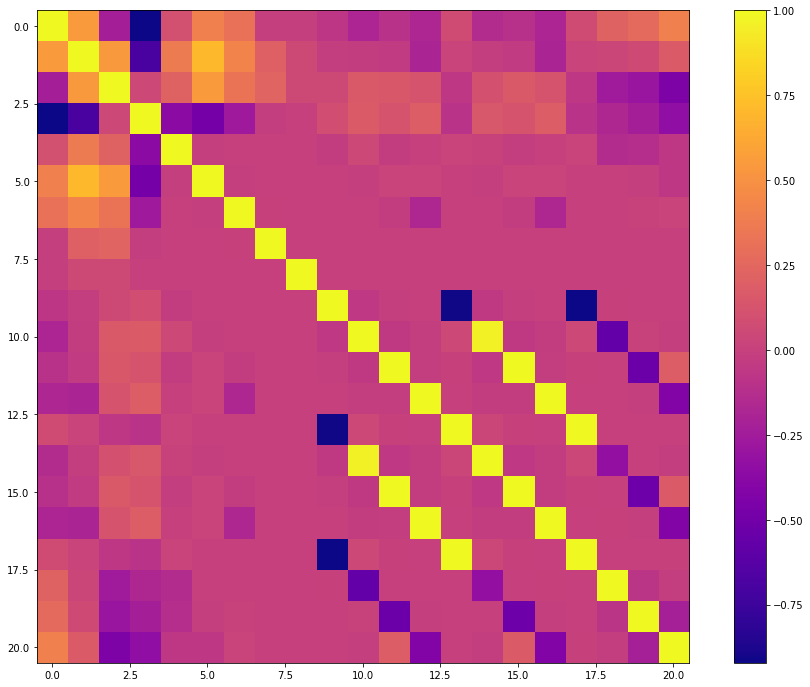

Inverting...
32184.425161269482
Re-inverting...
15.634677727107745
Inverting...
32658.676274683985
Re-inverting...
26.244204597863845
Saved Fishers


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in double_scalars
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in true_divide
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in double_scalars
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in true_divide
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in double_scalars
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in double_scalars
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 24 is out of bounds for axis 0 with size 21

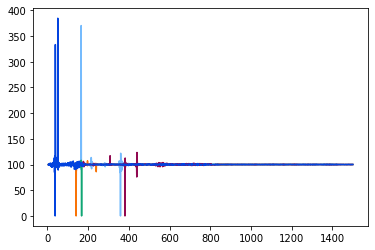

In [17]:
# No Planck Fisher matrices

### 4MOST 3x2pt only LCDM ###
#4MOST
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### 4MOST 3x2pt only wCDM ###
LensparamNames = np.array(["OmM","As","w0","logT_AGN","b0","b1","b2","b3","b4","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
LensparamValues = np.array([omegaM, As, w0, logT_AGN, b0, b1, b2, b3, b4, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
LensparamDevs = np.array([omegaMDev,AsDev/As,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES 3x2pt only wCDM ###
#LensparamNames = np.array(["OmM","As","w0","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, w0, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,w0Dev,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
# 1x2pt
#LensparamNames = np.array(["OmM","As","w0","logT_AGN","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"])
#LensparamValues = np.array([omegaM, As, w0, logT_AGN, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA])
#LensparamDevs = np.array([omegaMDev,AsDev/As,w0Dev,logT_AGNDev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev])
#LensparamNames = np.array(["OmM","As","w0","logT_AGN","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, w0, logT_AGN, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,w0Dev,logT_AGNDev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
### DES 3x2pt only LCDM ###
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","dz0","dz1","dz2","dz3","dz4","dz5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, dz0, dz1, dz2, dz3, dz4, dz5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,dz0Dev,dz1Dev,dz2Dev,dz3Dev,dz4Dev,dz5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","cb0","cb1","cb2","cb3","cb4","cb5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, cb0, cb1, cb2, cb3, cb4, cb5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,cb0Dev,cb1Dev,cb2Dev,cb3Dev,cb4Dev,cb5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])

#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","Ssigmab0","Ssigmab1","Ssigmab2","Ssigmab3","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, Ssigmab0, Ssigmab1, Ssigmab2, Ssigmab3, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,Ssigmab0Dev,Ssigmab1Dev,Ssigmab2Dev,Ssigmab3Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","sigmab0","sigmab1","sigmab2","sigmab3","sigmab4","sigmab5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, sigmab0, sigmab1, sigmab2, sigmab3, sigmab4, sigmab5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,sigmab0Dev,sigmab1Dev,sigmab2Dev,sigmab3Dev,sigmab4Dev,sigmab5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev])

#LensparamNames = np.array(["OmM","As","logT_AGN","b0","b1","b2","b3","b4","b5","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, b0, b1, b2, b3, b4, b5, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,b0Dev,b1Dev,b2Dev,b3Dev,b4Dev,b5Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
# 1x2pt
#LensparamNames = np.array(["OmM","As","logT_AGN","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"])
#LensparamValues = np.array([omegaM, As, logT_AGN, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev])
#LensparamNames = np.array(["OmM","As","logT_AGN","Ssigmab0","Ssigmab1","Ssigmab2","Ssigmab3","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3"])
#LensparamValues = np.array([omegaM, As, logT_AGN, Ssigmab0, Ssigmab1, Ssigmab2, Ssigmab3, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,Ssigmab0Dev,Ssigmab1Dev,Ssigmab2Dev,Ssigmab3Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev])
#LensparamNames = np.array(["OmM","As","logT_AGN","Ssigmab0","Ssigmab1","Ssigmab2","Ssigmab3","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, Ssigmab0, Ssigmab1, Ssigmab2, Ssigmab3, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,Ssigmab0Dev,Ssigmab1Dev,Ssigmab2Dev,Ssigmab3Dev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As","logT_AGN","AIA0","AIA1","AIA2","AIA3","etaIA0","etaIA1","etaIA2","etaIA3","shearm1","shearm2","shearm3","shearm4"])
#LensparamValues = np.array([omegaM, As, logT_AGN, AIA, AIA, AIA, AIA, etaIA, etaIA, etaIA, etaIA, shearm, shearm, shearm, shearm])
#LensparamDevs = np.array([omegaMDev,AsDev/As,logT_AGNDev,AIADev,AIADev,AIADev,AIADev,etaIADev,etaIADev,etaIADev,etaIADev,shearmDev,shearmDev,shearmDev,shearmDev])
#LensparamNames = np.array(["OmM","As"])
#LensparamValues = np.array([omegaM, As])
#LensparamDevs = np.array([omegaMDev,AsDev/As])


galObservables = {"CMB":False, "CMBLens":False, "ISW":False, "Gal-Gal":True, "Lens-Lens":True, "Gal-Gal Lens":True, "CMBLens-Lens":False}
GalModel = FullForecast(observables=galObservables, paramNames=LensparamNames, paramValues=LensparamValues, 
                        paramDevs=LensparamDevs, ellArray=ellArray, lenseInstruments=lenseInstruments, 
                        galInstruments=galInstruments, CMBInstruments=[CMB,CMBEMode], CMBellArray=ellArrayCMB, 
                        CMBParamNames=CMBparamNames, CMBParamValues=CMBparamValues, 
                        translationToCAMBParams=translationToCAMB, cambParamDevs=cambParamDevs, 
                        hierarchy="normal", suffix="")

FisherGal = FisherMatrix(Model=GalModel)
print(FisherGal.meanDevArray)
print(FisherGal.meanDevArray.shape)
print(len(FisherGal.meanDevArray))
print(len(FisherGal.meanDevArray[0]))
GalDataLen = len(FisherGal.meanDevArray[0])
FisherMatGal = FisherGal.generateFisher(condNum=True, subMatrix=True, subMatrixLen=round(GalDataLen/len(ellArray)), plotCovarMat=False, plotSubCovar=False)
variance = np.zeros((len(FisherMatGal)))
for i in range(len(FisherMatGal)):
	variance[i] = FisherMatGal[i][i]**0.5
FisherMatGalCorr = np.zeros(FisherMatGal.shape)
for i in range(len(FisherMatGal)):
	for j in range(len(FisherMatGal)):
		FisherMatGalCorr[i][j] = FisherMatGal[i][j]/(variance[i]*variance[j])
print("Galaxy Correlation Fisher condition number:")
print(np.linalg.cond(FisherMatGalCorr, 'fro'))
plt.figure(figsize=(16,12))
plt.imshow(FisherMatGalCorr, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()
print("Galaxy Fisher condition number:")
print(np.linalg.cond(FisherMatGal, 'fro'))
fisherGalMatrices = [FisherMatGal]

# Marginalised parameter options
# 4MOST LCDM
#marginalisedIndices = [19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
# 4MOST wCDM
marginalisedIndices = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3]
# DES wCDM
#marginalisedIndices = [33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3]
# DES LCDM
#marginalisedIndices = [26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]

#marginalisedIndices = [30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
# WL wCDM
#marginalisedIndices = [11,10,9,8,7,6,5,4,3]
#marginalisedIndices = [15,14,13,12,11,10,9,8,7,6,5,4,3]
# WL LCDM
#marginalisedIndices = [10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [14,13,12,11,10,9,8,7,6,5,4,3,2]
#marginalisedIndices = [18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2]
# Optimal
#marginalisedIndices = []


# Fisher matrix transformation
JacS8 = np.identity(len(FisherMatGal))
Jac = np.identity(len(FisherMatGal))
JacS8[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = DES3x2ptwCDMJacS8
Jac[0:min(marginalisedIndices), 0:min(marginalisedIndices)] = DES3x2ptwCDMJac
# If no transformation required
#JacS8 = DES3x2ptLCDMJacS8
#Jac = DES3x2ptLCDMJac

print(FisherMatGal)
FisherMatGalUnmargin = FisherGal.transformFisher(jacobian=Jac, fisherMatrix=FisherMatGal)
FisherMatGalUnmarginS8 = FisherGal.transformFisher(jacobian=JacS8, fisherMatrix=FisherMatGal)
variance = np.zeros((len(FisherMatGalUnmarginS8)))
for i in range(len(FisherMatGalUnmarginS8)):
	variance[i] = FisherMatGalUnmarginS8[i][i]**0.5
FisherMatGalCorr = np.zeros(FisherMatGalUnmarginS8.shape)
for i in range(len(FisherMatGalUnmarginS8)):
	for j in range(len(FisherMatGalUnmarginS8)):
		FisherMatGalCorr[i][j] = FisherMatGalUnmarginS8[i][j]/(variance[i]*variance[j])
print("Galaxy Correlation Fisher condition number:")
print(np.linalg.cond(FisherMatGalCorr, 'fro'))
plt.figure(figsize=(16,12))
plt.imshow(FisherMatGalCorr, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

FisherGalGal = FisherGal.marginaliseOverParameters(FisherMatrix=FisherMatGalUnmargin, paramIndices=marginalisedIndices)
FisherGalGalS8 = FisherGal.marginaliseOverParameters(FisherMatrix=FisherMatGalUnmarginS8, paramIndices=marginalisedIndices)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptwCDM.dat', FisherGalGal)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptwCDMS8.dat', FisherGalGalS8)
print("Saved Fishers")
print("3x2pt Done.")

In [18]:
# Fisher matrix finalising and saving

suffix="Growth"
model="nuwCDM"


print("Beginning Fisher analysis.")
FisherMatPlanck = FisherPlanck+FisherPlanckExt
FisherMatGal = FisherGalMat+FisherPlanckExt
FisherMatLens = FisherLensMat+FisherPlanckExt
FisherMatComplete = FisherFullMat+FisherPlanckExt
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+suffix+model+'.dat', FisherMatGal)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+suffix+model+'.dat', FisherMatLens)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+suffix+model+'.dat', FisherMatPlanck)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+suffix+model+'.dat', FisherMatComplete)

FisherMatPlanckS8 = FisherPlanckS8+FisherPlanckExtS8
FisherMatGalS8 = FisherGalMatS8+FisherPlanckExtS8
FisherMatLensS8 = FisherLensMatS8+FisherPlanckExtS8
FisherMatCompleteS8 = FisherFullMatS8+FisherPlanckExtS8
print("Fisher analysis done.")
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+suffix+model+'sigma8.dat', FisherMatGalS8)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+suffix+model+'sigma8.dat', FisherMatLensS8)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+suffix+model+'sigma8.dat', FisherMatPlanckS8)
np.savetxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+suffix+model+'sigma8.dat', FisherMatCompleteS8)



Beginning Fisher analysis.
Fisher analysis done.
